# Charakterystyka sytuacji mieszkanowej w Białymstoku:

## 1. Metodologia badania

### 1.1 Cel i przedmiot badania

Celem badania jest przeanalizowanie sytuacji mieszkaniowej panującej w mieście Białystok i jego okolicy (miejscowości w promieniu do 50 km od miasta) oraz sprwadzeniu które z cech wystawianch mieszkań w ogłoszeniach w seriwsie Oto Dom mogą wpływać na zmianę ceny mieszkania. Charakterystyka sytuacji ogłoszeń na sprzedaż mieszkań w Białymstoku może pomóc w wyborze potencjalnego mieszkania do zakupu, wpłynąć na świadomosć użytkownika serwisu Oto Dom na które zmienne warto jest zwracać szczególną uwagę przy poszukiwaniach mieszkania pod zakup.

Analiza obejmuje jedynie ogłoszenia dotyczące sprzedaży mieszkań. Białystok jest miastem w którym również występuje zabudowa w postaci domów jednorodzinnych, jednakże w ostatnich latach w mieście obserwuje się wzmożone budownictwo bloków. Na zakup domu mogą wpływać zupełnie inne czynniki niż na zakup mieszkań. Osoby zainteresowane domem jednorodzinnym potencjalnie mogą również bardziej interesować się wolną działką na której mogą wybudować dom wg własnego projektu. W serwisie oto dom są również dostępne mieszkania budowane przez developerów co umożliwia również analizę porównawczą pomiędzy rynkiem pierwotnym, a wtórnym w mieście Białystok. 

Jako wartość porównania ceny w badaniu wzięto cenę za metr kwadratowy. Jest najbardziej optymalny wskaźnik porówawczy ceny mieszkań różnego typu.

### 1.2 Dane
Dane zostały pobrane z serwisu Oto Dom w lutym 2024 roku za pomocą skryptu napisanego przez autora analizy (udostępnionego na portalu github: https://github.com/baranowskimac/Praca_Zaliczeniowa). Przeanalizowano 1877 unikalnych ofert sprzedaży mieszkań, które znajdują się w Białymsotku lub w okolicach miasta (w promieniu do 50 km).

### 1.3 Hipotezy badawcze
1. Przeciętna cena mieszkania za metr kwadratowy różni się z względu na:
    - położenie mieszkania 
    - wielkość mieszkania
    - podmiot wystawiający mieszkanie na sprzedaż
    - pochodzenie mieszkania (rynek pierwotny vs. rynek wtórny)
    - dodatkowe cechy, które są dostępne w danej ofercie tj:
        - dodatkow wyposażenie mieszkania
            - piekarnik
            - kuchenka
            - telefon
            - meble
            - zmywarka
            - pralka
            - lodówka
            - telewizor
        - dodatkowe pomieszczenia przypisan do mieszkania
            - garaż lub miejsce parkingowe
            - dodatkowe pomieszczenie użytkowe
            - ogórdek
            - piwnica
            - taras
        - wygoda:
            - winda
            - klimatyzacja
        - dodatkowe cechy mieszkania:
            - balkon
            - oddzielna kuchnia
        - media
            - telewizja kablowa
            - internet
        - bezpieczeństwo
            - system alarmowy
            - położenie mieszkania na terenie zamkniętym
            - monitoring bądź ochrona osiedla na którym znajduje się mieszkanie
            - drzwy antywłamaniowe na wyposażeniu
            - domofon
            - rolety antywłamaniowe na wyposażeniu    

### 1.4 Pytania badawcze
1. Jaka jest przeciętna cena za metr kwadratowy mieszkania w Białymstoku?
2. Czy przeciętna centa za metr kwadratowy różni się z względu na to, czy mieszkanie znajduje się w granicach miasta czy poza jego granicami?
3. Czy istnieją różnice w przeciętnej cenie metra kwadratowego pomiędzy poszczególnymi dzielnicami Białegostoku?
4. Czy istnieje różnica w przeciętnej cenie metra kwadratowego z względu na podmiot wystawiający ogłoszenie (oferty firm vs. oferty osób prywatnych)
5. Czy istnieje różnica w przeciętnej cenie metra kwadratowego z względu na rynek pierwotny i wtórny?
6. Czy wraz z wzrostem wielkości mieszkania maleje cena za metr kwadratowy?
7. Czy istnieją dodatkowe czynniki, które są dostępne w opisach ogłoszeń, a które wpływają na cenę metra kwadratowego?




## 2. Wczytanie oraz przygotowanie danych

### 2.1 Wczytanie bibliotek oraz danych

In [1]:
import pandas as pd
import glob
import gmaps
import gmaps.datasets
import pickle
import datetime as dt
import numpy as np
import re
import warnings
import plotly.express as px
import seaborn as sns
from ipywidgets.embed import embed_minimal_html
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from IPython.display import Markdown as md

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# wczytanie surowych danych
oto_files = glob.glob(f'./batch/*.pkl')
full_df = []
for i in oto_files:
    with open(i, 'rb') as f:
        one_batch = pickle.load(f)
    full_df.append(one_batch)

# konwersja zagnieżdżonych słowników do df    
return_df = []
for i in range(len(full_df)):
    one_df = pd.DataFrame.from_dict(full_df[i], orient='columns')
    return_df.append(one_df)
return_df = pd.concat(return_df).reset_index(drop=True)

In [4]:
print('number of raw rows:')
print(return_df.shape)
print('-------------')
print('number of unique rows:')
print(return_df['id'].nunique())
# remove duplicated rows
df_without_duplicates = return_df.drop_duplicates(subset='id')
print('-------------')
print('number of rows after removing duplicated rows:')
print(df_without_duplicates.shape)

number of raw rows:
(3014, 42)
-------------
number of unique rows:
1877
-------------
number of rows after removing duplicated rows:
(1877, 42)


**Podsumowanie:**

Pobrane dane zawierają zduplikowane wiersze. Jest to konsekwencja tego, iż pobieranie danych zostało rozłożone na dwie tury - w odstępie jednego miesiąca. <br>
**Wniosek:** część ogłoszeń sprzedaży mieszkań z różnycy względów jest mniej popularna niż inne i oferty są dostępne przez dłuższy czas niż inne. <br> 

### 2.2 Przygotowanie danych

Pobrane dane wymagają przygotowania do dalszej eksploracji:
- ustandaryzowanie dat: konwersja z formatu timestamp do formatu daty (czas i godzina dodania ogłoszenia do dalszej eksploracji jest nieporzebna)
- rozpakowanie zagnieżdżonych list danych opisowych 
- rozpakowanie zagnieżdżonych danych ilościowych charakteryzujących wystawione mieszkania na sprzedaż
- ujednolicenie nazw kolumn
- konwersja danych na typy numeryczne/tekstowe 
- wstępna eksplorcja zmiennych

In [5]:
# usunięcie czasu dodania ogłoszenia - pozostawienie tylko inofrmacji o dniu
df_without_duplicates['createdAt'] = df_without_duplicates['createdAt'].str[:10]
df_without_duplicates['modifiedAt'] = df_without_duplicates['modifiedAt'].str[:10]

In [6]:
# rozpakowanie danych tekstowych z list do nadających się analizy danych typu 'string'
df_without_duplicates['Construction_status'] = [','.join(i) for i in df_without_duplicates['Construction_status']]
df_without_duplicates['Extras_types'] = [','.join(i) for i in df_without_duplicates['Extras_types']]
df_without_duplicates['Floor_no'] = [','.join(i) for i in df_without_duplicates['Floor_no']]
df_without_duplicates['Rooms_num'] = [','.join(i) for i in df_without_duplicates['Rooms_num']]
df_without_duplicates['Security_types'] = [','.join(i) for i in df_without_duplicates['Security_types']]
df_without_duplicates['PriceRange'] = [','.join(i) for i in df_without_duplicates['PriceRange']]
df_without_duplicates['street_id'] = [np.nan if i == {} else i for i in df_without_duplicates['street_id']]
df_without_duplicates['street_name'] = [np.nan if i == {} else i for i in df_without_duplicates['street_name']]
df_without_duplicates['district_id'] = [np.nan if i == {} else i for i in df_without_duplicates['district_id']]
df_without_duplicates['district_name'] = [np.nan if i == {} else i for i in df_without_duplicates['district_name']]

In [7]:
# rozpakowanie dodatkowych zmiennych opisowych charakteryzujących wystawione mieszkania na sprzedaż 
# do oddzielnych kolumn oraz otagowanie czy analizowane mieszkanie posiada daną cechę (1) czy nie (0)

# rozpakowanie zagnieżdżonych list do jednej listy
feature_ls = []
for i in df_without_duplicates['features']:
    feature_ls += i
# sprawdzenie uniklanych wartości w liście wszystkich cech   
feature_ls = list(set(feature_ls))

# pętla po każdym elemencie listy cech i sprawdzenie czy dane mieszkanie posiada daną cechę czy nie
for i in feature_ls:
    df_without_duplicates[i] = [1 if i in x else 0 for x in df_without_duplicates['features']]

# zmiana nazw kolumn 
df_without_duplicates.rename(columns={
    'telewizja kablowa': 'feat_telewizja kablowa',
    'dwupoziomowe': 'feat_dwupoziomowe',
    'ogródek': 'feat_ogródek',
    'garaż/miejsce parkingowe': 'feat_garaż/miejsce parkingowe',
    'taras': 'feat_taras',
    'teren zamknięty': 'feat_teren zamknięty',
    'piwnica': 'feat_piwnica',
    'lodówka': 'feat_lodówka',
    'pom. użytkowe': 'feat_pom. użytkowe',
    'telewizor': 'feat_telewizor',
    'telefon': 'feat_telefon',
    'domofon / wideofon': 'feat_domofon / wideofon',
    'kuchenka': 'feat_kuchenka',
    'oddzielna kuchnia': 'feat_oddzielna kuchnia',
    'internet': 'feat_internet',
    'pralka': 'feat_pralka',
    'monitoring / ochrona': 'feat_monitoring_ochrona',
    'zmywarka': 'feat_zmywarka',
    'meble': 'feat_meble',
    'winda': 'feat_winda',
    'balkon': 'feat_balkon', 
    'drzwi / okna antywłamaniowe': 'feat_drzwi / okna antywłamaniowe',
    'rolety antywłamaniowe': 'feat_rolety antywłamaniowe',
    'klimatyzacja': 'feat_klimatyzacja',
    'piekarnik': 'feat_piekarnik',
    'system alarmowy': 'feat_system alarmowy' 
}, inplace = True)

# sprawdzenie liczby udogodnień w danym ogłoszeniu
df_without_duplicates['n_features'] = [len(i) for i in df_without_duplicates['features']]

In [8]:
# zmiana zmiennej opisowwej charakteryzującej poziom bloku na którym znajduje się mieszkanie na liczbę
# białystok charakteryzuje się stosunkowo niską zabudową i mało jest budynków które mają więcej niż 10 pięter
# w całym zbiorze danych było 38 takich ogłoszeń - dlatego mieszkania które znajdują się na piętrze wyższym niż 10 
# zostały opisane jako piętro 11 (co będzie znaczyło 11 i wyżej) - w celu ułatwienia dalszej analizy
# mieszkania na poddaszu - garret - było tylko jedno takie ogłoszenie - i zostało scharakteryzowane jako brak danych.

dict_floor_mapping = {
    'cellar': -1,
    'ground_floor': 0,
    'floor_1': 1,
    'floor_2': 2,
    'floor_3': 3,
    'floor_4': 4,
    'floor_5': 5,
    'floor_6': 6,
    'floor_7': 7,
    'floor_8': 8,
    'floor_9': 9,
    'floor_10': 10,
    'floor_higher_10': 11,
    'garret': np.nan,
    '': np.nan
}
df_without_duplicates['Floor_no'] = df_without_duplicates['Floor_no'].map(dict_floor_mapping)

In [9]:
# rozpakowanie zagnieżdżonych danyc liczbowych
df_without_duplicates['Build_year'] = [np.nan if len(i) == 0 else i for i in df_without_duplicates['Build_year']]
df_without_duplicates['Building_floors_num'] = [np.nan if len(i) == 0 else i for i in df_without_duplicates['Building_floors_num']]
df_without_duplicates['Price'] = [np.nan if i == {} else i for i in df_without_duplicates['Price']]
df_without_duplicates['Price_per_m'] = [np.nan if i == {} else i for i in df_without_duplicates['Price_per_m']]

In [10]:
# konwersja zmiennych na dane numeryczne

df_without_duplicates['Area'] = df_without_duplicates['Area'].astype('float') 
df_without_duplicates['Build_year'] = df_without_duplicates['Build_year'].astype('float')
df_without_duplicates['Building_floors_num'] = df_without_duplicates['Building_floors_num'].astype('float')

Przy zmiennej o liczbie pokoi mamy do czynienie kiedy w dwóch przypadkach zmienna jest oznaczona jako "more".Warto się przyjrzeć tym dwóm przypadkom

In [11]:
df_without_duplicates[df_without_duplicates['Rooms_num']=='more'][['id', 'description', 'Rooms_num', 'advertiserType']]

,id,description,Rooms_num,advertiserType
338,64529229,<p>Polecam Państwu ofertę garażu indywidualneg...,more,private
1531,62942670,<p>****** KOMPLEKS MIESZKAŃ *******<br/>Zapras...,more,business


In [12]:
(
    df_without_duplicates[
        (df_without_duplicates['Rooms_num']=='more')
        & (df_without_duplicates['id']==64529229)].reset_index()['description'][0]
)

'<p>Polecam Państwu ofertę garażu indywidualnego w budynku\xa0 przy ul.42 Pułku Piechoty- os. Wygoda.</p>\r\n<p>\xa0o powierzchni 16,07 m2 położonego w hali garażowej na kondygnacji -1\xa0</p>\r\n<p>Przy zakupie\xa0 Kupujący będzie zwolniony z PCC 2%\xa0</p>\r\n<p>Zapraszam do oglądania.</p>'

In [13]:
(
    df_without_duplicates[
        (df_without_duplicates['Rooms_num']=='more')
        & (df_without_duplicates['id']==62942670)].reset_index()['description'][0]
)

'<p>****** KOMPLEKS MIESZKAŃ *******<br/>Zapraszamy Państwa na prezentację  kompleksu mieszkań w budynku  usługowo-mieszkaniowym znajdującego się  na osiedlu Białostoczek.<br/>Nieruchomość położona jest w części osiedla zabudowy domów jednorodzinnych<br/>Na sprzedaż 2 piętra budynku </p><p>Dostępnych jest 6 mieszkań w stanie deweloperskim w celu inwestycyjnym pod wynajem. </p><p>Dostępne mieszkania<br/>- jednopokojowe z aneksem kuchennym oraz łazienką.<br/>Powierzchnia  ok 32 m 2.</p><p>- trzy mieszkania, które składają się  salonu z otartą kuchnią, osobnej sypialni oraz łazienki. <br/>Powierzchnia jednego mieszkania  ok 44 m 2. </p><p>- dwa mieszkanie trzypokojowe, które składa się salonu z otwartą kuchnią, dwóch osobnych sypialni, łazienki oraz przedpokoju. <br/>Powierzchnia ok 60 m 2.</p><p>Każda nieruchomość ma własne liczniki. Mieszkania posiadają klatkę schodową oraz znajdują się w kameralnym budynku z 2017 roku. Nowoczesna bryła nieruchomości. </p><p>Polecamy !!!!<br/>Zapraszamy

**Podsumowanie** <br>
Opisy ogłoszeń wskazują, iż jedno z nich jest ofertą najmu garażu (w bloku, dlatego zapewne znalazło się wśrod ofert mieszkań przy wyborze filtrów w serwisie oto dom) a drugie jest ofertą developera na sprzedaż kilku mieszkań jednocześnie (oferta wielowmieszkaniowa)
<br>
w takim przypadku można skategoryzować zmienną rooms number w przypadku pierwszego ogłoszenia na 0
w drugim przypadku można uzupełnić tę informacją przeciętną liczbą pokoi dostepnym w DS.

In [14]:
# przeciętna liczba pokoi dla całego DS - w przybliżeniu 3
df_without_duplicates[df_without_duplicates['Rooms_num'] != 'more']['Rooms_num'].astype('float').mean()
# 62942670

2.686933333333333

In [15]:
df_without_duplicates.loc[df_without_duplicates['id'] == 64529229, 'Rooms_num'] = 0
df_without_duplicates.loc[df_without_duplicates['id'] == 62942670, 'Rooms_num'] = 3 #przecietna liczba pokoi dla całego DS
df_without_duplicates['Rooms_num'] = df_without_duplicates['Rooms_num'].astype('float')

In [16]:
# konwersja zmiennych na dane kategoryczne
df_without_duplicates['id'] = df_without_duplicates['id'].astype('str') 

In [17]:
# rozpakowanie danych dotyczących przedziału cenowych ofert sprzedaży mieszkań
match_char_min = r'.*(?=-)'
df_without_duplicates['PriceRange_min'] = [np.nan if i == '' else re.search(match_char_min, i)[0] for i in df_without_duplicates['PriceRange']]
match_char_max = r'(?<=-).*'
df_without_duplicates['PriceRange_max'] = [np.nan if i == '' else re.search(match_char_max, i)[0] for i in df_without_duplicates['PriceRange']]
#  usunięcie zbędnych kolumn
df_without_duplicates.drop(['PriceRange', 'AreaRange'], axis=1, inplace = True)

**Podsumowanie:**

Pobrane dane wymagały przygotowania do dalszej analizy - ich transformacji i czyszczeniu. Dane charakteryzują się dobrą jakością, jednakże wymagały przygotowania do dalszych prac.
Jest to konswkwenacja pobrania danych bezpośredno z serwisu Oto Dom przy wykorzystaniu bibliotek Beautiful Soap i Request i pobierania zagnieżdżonych informacj (JSON) bezpośrednio z serwisu.

### 2.3 Eksploracja miennych kategorycznych

In [18]:
df_without_duplicates.head()

,lang,id,relativeUrl,publicId,market,advertiserType,title,description,url,slug,createdAt,modifiedAt,features,MarketType,Area,Build_year,Building_floors_num,Country,City,City_id,Construction_status,Extras_types,Floor_no,ProperType,Province,Rooms_num,Security_types,Price,Price_per_m,hidePrice,latitude,longitude,street_id,street_name,district_id,district_name,city_id,city_name,province_id,province_name,feat_zmywarka,feat_telewizor,feat_teren zamknięty,feat_piekarnik,feat_telewizja kablowa,feat_pom. użytkowe,feat_internet,feat_ogródek,feat_taras,feat_lodówka,feat_drzwi / okna antywłamaniowe,feat_winda,feat_telefon,feat_balkon,feat_system alarmowy,feat_monitoring_ochrona,feat_rolety antywłamaniowe,feat_pralka,feat_klimatyzacja,feat_piwnica,feat_kuchenka,feat_dwupoziomowe,feat_domofon / wideofon,feat_meble,feat_garaż/miejsce parkingowe,feat_oddzielna kuchnia,n_features,PriceRange_min,PriceRange_max
0,pl,64672843,/pl/oferta/nowe-mieszkanie-bez-kredytu-dojscie...,4nmmn,PRIMARY,business,"Nowe mieszkanie BEZ KREDYTU, dojście do własno...",<p>Nowe mieszkanie w systemie spółdzielczego l...,https://www.otodom.pl/pl/oferta/nowe-mieszkani...,nowe-mieszkanie-bez-kredytu-dojscie-do-wlasnos...,2023-10-03,2024-02-02,"[domofon / wideofon, piekarnik, kuchenka, balk...",primary,85.24,2025.0,3.0,Polska,zabludow,2927,ready_to_use,"balcony,garage,lift",3.0,mieszkanie,podlaskie,3.0,entryphone,154248.0,1810.0,0,53.015830,23.327345,50986,50986,NaN,NaN,2927,2927,10,10,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,6,100001,250000
1,pl,64961466,/pl/oferta/sprzedam-mieszkanie-w-rewelacyjnej-...,4ozrA,SECONDARY,private,Sprzedam mieszkanie w rewelacyjnej lokalizacji,<p>Oferta sprzedaży przestronnego i dobrze ośw...,https://www.otodom.pl/pl/oferta/sprzedam-miesz...,sprzedam-mieszkanie-w-rewelacyjnej-lokalizacji...,2024-01-06,2024-01-31,"[telewizja kablowa, internet, telefon, domofon...",secondary,78.26,2017.0,2.0,Polska,bialystok,204,ready_to_use,balcony,1.0,mieszkanie,podlaskie,4.0,entryphone,815000.0,10414.0,0,53.126596,23.118013,44637,44637,16972,16972,204,204,10,10,1,1,0,1,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,12,750001,1000000
2,pl,65027560,/pl/oferta/mieszkanie-na-sprzedaz-53m2-bialyst...,4oQDC,SECONDARY,private,Mieszkanie na sprzedaż 53m2 Białystok ul. Wiejska,"<p>Mieszkanie słoneczne, dwustronne.</p>\r\n<p...",https://www.otodom.pl/pl/oferta/mieszkanie-na-...,mieszkanie-na-sprzedaz-53m2-bialystok-ul-wiejs...,2024-01-24,2024-01-30,"[telewizja kablowa, telefon, domofon / wideofo...",secondary,53.20,1994.0,4.0,Polska,bialystok,204,ready_to_use,"balcony,basement,separate_kitchen",1.0,mieszkanie,podlaskie,2.0,entryphone,453000.0,8515.0,0,53.114156,23.145727,49856,49856,3196,3196,204,204,10,10,0,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,1,1,0,1,12,250001,500000
3,pl,65060994,/pl/oferta/bacieczki-35-5-m-2-ID4oZkS,4oZkS,SECONDARY,business,"** Bacieczki ** 35,5 M 2 **","<p>***35,5M2***BACIECZKI***III PIĘTRO**</p><p>...",https://www.otodom.pl/pl/oferta/bacieczki-35-5...,bacieczki-35-5-m-2-ID4oZkS,2024-02-02,2024-02-02,"[meble, balkon, piwnica, oddzielna kuchnia, po...",secondary,35.50,2003.0,3.0,Polska,bialystok,204,ready_to_use,"balcony,basement,separate_kitchen,usable_room",3.0,mieszkanie,podlaskie,1.0,,329000.0,9268.0,0,53.151007,23.096583,NaN,NaN,642,642,204,204,10,10,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,5,250001,500000
4,pl,64735773,/pl/oferta/bezposrednio-ul-belzy-os-bialystocz...,4nCJn,PRIMARY,private,BEZPOŚREDNIO ul. Bełzy oś. Białystoczek bez PCC,<p>Sprzedam <strong>NOWE</strong> <strong>2-po...,https://www.otodom.pl/pl/oferta/bezposrednio-u...,bezposrednio-ul-belzy-os-bialystoczek-bez-pcc-...,2023-10-21,2024-02-02,"[telewizja kablowa, internet, telefon, drzwi /...",primary,42.62,NaN,5.0,Polska,bialystok,204,,balcony,5.0,mieszkanie,podlaskie,2.0,"anti_burglary_door,entryphone",555000.0,13022.0,0,53.152501,23.158459,,,NaN,NaN,204,204,10,10,1,0,0,1,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,12,500001,750000


Analiza kilku pierwszych wierszy pokazuje, że w danych brakuje istotnej zmiennej jaką jest nazwa dzielnicy miasta, w której znajduje się sprzedawane mieszkanie. <br>
Z serwisu oto dom zostały pobrane nazwy dzielnic oraz przyporządkowane im 'id' i w następnym kroku dodane do danych.
W sytuacji jeżeli ogłoszenie jest spoza Białegostoku do nazwy dzielnicy zostanie przypisana nazwa miejscowości.

In [19]:
disctrict_codes = {
    'Centrum': '187298',
    'Antoniuk': '253',
    'Antoniuk Fabryczny': '20054', 
    'Dojlidy': '21872',
    'Leśna Dolina': '3553',
    'Białostoczek': '1746',
    'Jaroszówka': '20209',
    'Bema': '4459',
    'Wysoki Stoczek': '4286',
    'Sienkiewicza': '6714',
    'Wygoda': '4945',
    'Dziesięciny': '1019',
    'Bojary': '4096',
    'Piasta': '3422',
    'Piasta I': '104024',
    'Piasta II': '96300',
    'Nowe Miasto': '3196',
    'Piaski': '1106',
    'Zielone Wzgórza': '3434',
    'Bacieczki': '642',
    'Przydworcowe': '3721',
    'Skorupy': '14406',
    'Starosielce': '4257',
    'Zawady': '14381',
    'Młodych': '16972',
    'Mickiewicza': '5421',
    'Słoneczny Stok': '5419',
    'Dojlidy Górne': '9962',
    'Bagnówka': '53840',
    'os-tysiaclecia': '23095',
    'Marczuk': '61920'
}
districts = (
    pd.DataFrame.from_dict(disctrict_codes, orient='index')
    .reset_index()
    .rename(columns={'index': 'district_name2', 0: 'district_id'})
)
# połączenie danych po 'district id'
df_without_duplicates = df_without_duplicates.merge(districts, how = 'left', on = 'district_id')
# nadpisanie district name nazwą miejscowości jeżeli mieszkania na sprzedaż znajduje się poza granicami miasta Białystok
df_without_duplicates['district_name2'] = [y if y != 'bialystok' else x for x,y in zip(df_without_duplicates['district_name2'], df_without_duplicates['City'])]


Nazwy dzielnic w serwisie Oto Dom są stosunkowo rozdrobinione. Kilka dzielnic (tj. Piasta I, Piasta II, Antoniuk i Antoniuk Fabryczny Mogą zostać analizowane jako jedna grupa)

In [20]:
def unify_district_names(district):
    
    unify_district_names = {
        'Piasta': ['Piasta I', 'Piasta II', 'Piasta'],
        'Młodych': ['Marczuk', 'Młodych'],
        'Białostoczek': ['os-tysiaclecia', 'Białostoczek'],
        'Antoniuk': ['Antoniuk', 'Antoniuk Fabryczny']
    }
    return_value = ''
    for k,i in unify_district_names.items():
        if district in i:
            return_value = k
    if return_value == '':
        return_value = district 
    return return_value

df_without_duplicates['district_name3'] = list(map(unify_district_names, df_without_duplicates['district_name2']))
df_without_duplicates.drop(['district_name', 'district_name2'], axis=1, inplace = True)
df_without_duplicates.rename(columns={'district_name3':'district_name'}, inplace = True)
df_without_duplicates['district_name'] = df_without_duplicates['district_name'].astype('str')

In [21]:
# mark for the discritc name that add is outside from bialystok
df_without_duplicates['district_name'] = ['outside' if x != 'bialystok' else y for x,y in zip(df_without_duplicates['City'], df_without_duplicates['district_name'])]

### 2.4 Eksploracja zmiennych numerycznych

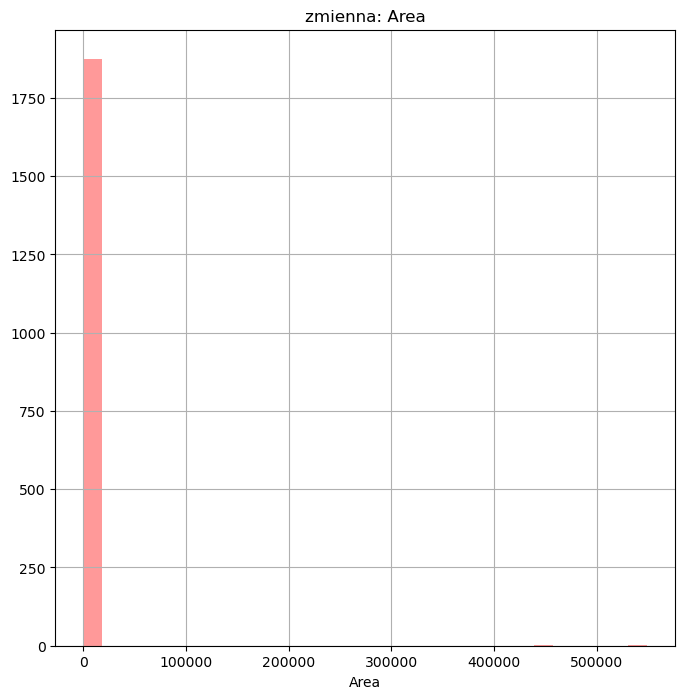

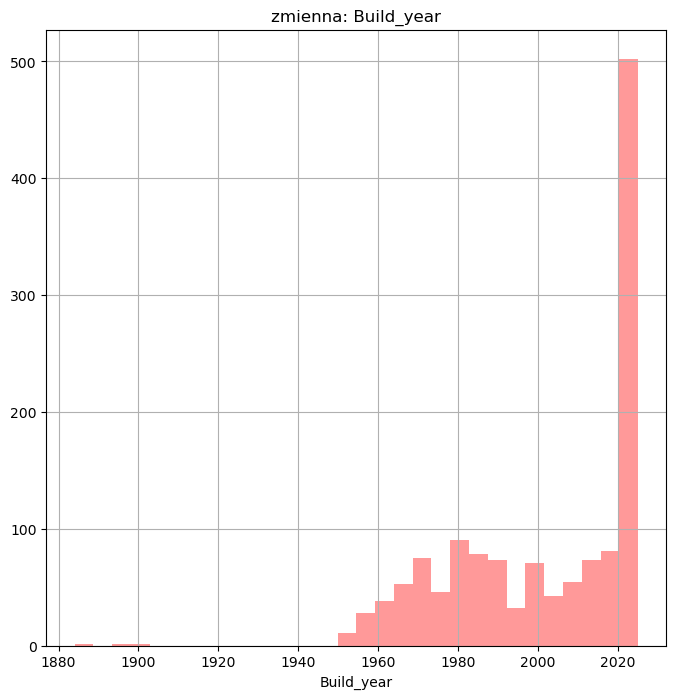

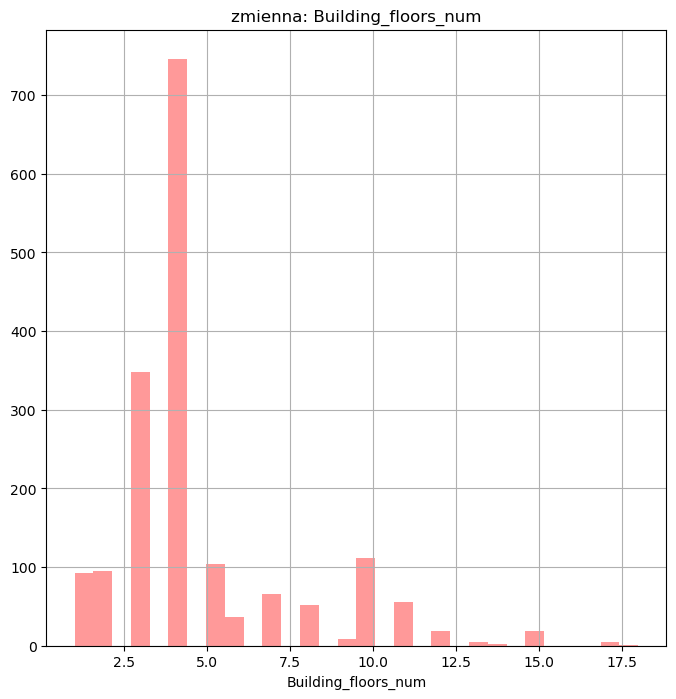

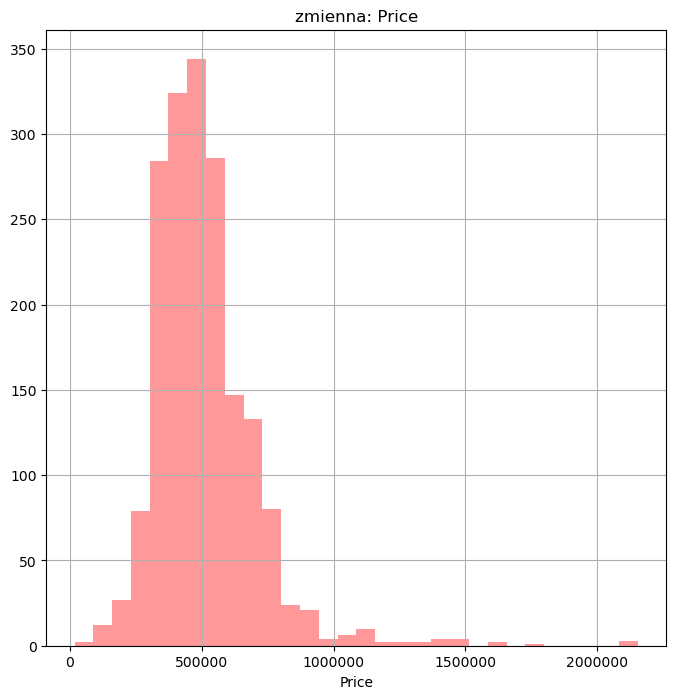

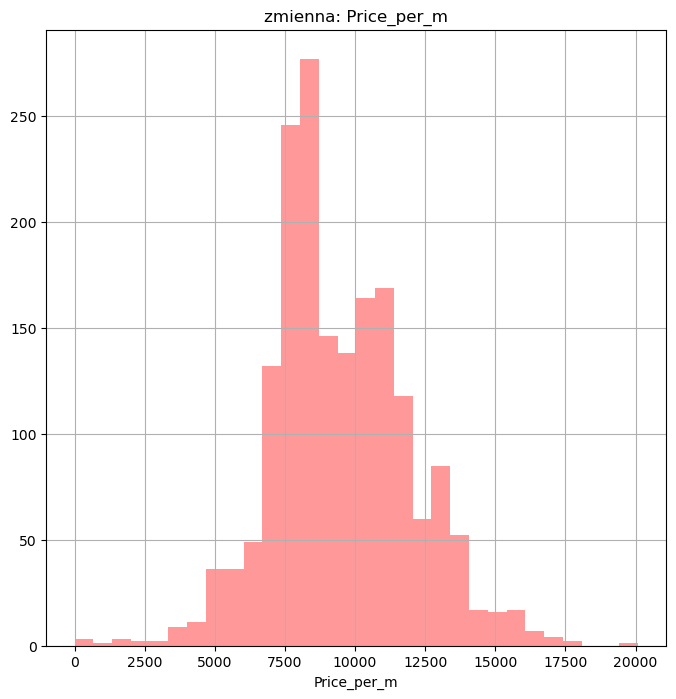

In [22]:
for i in ['Area', 'Build_year', 'Building_floors_num', 'Price', 'Price_per_m']:
    plt.figure(figsize=(8,8))
    sns.distplot(df_without_duplicates[i], bins=30, kde=False, color='red')
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f'zmienna: {i}')
    plt.grid()

Zmienna dotycząca powierzchni charakteryzuje się obserwacjami odstającymi, które wydają się błędne - mieszkania o powierzchni 100 000 metrów kwadratowych trudno jest sobie wyobrazić

In [23]:
display(df_without_duplicates[df_without_duplicates['Area'] > 100000][['Area', 'Price_per_m', 'Price', 'description']])

,Area,Price_per_m,Price,description
1024,549000.0,1.0,549000.0,<p><strong>OFERTA DEVELOPERSKA:</strong><br/>W...
1170,449000.0,1.0,449000.0,"<p><br/><strong>*** DZIEŃ OTWARTY, SOBOTA 3 LU..."
1793,450000.0,1.0,450000.0,<p><br/><strong>* 2 ODDZIELNE POKOJE * OS. MIC...


Są to dane w których brakuje podanych informacji o cenie za metr kwadratowy. Rozsądne wydaje się podzielenie tej wartości przez 1 0000 - jak pokazuje rozkład zmiennej ceny mieszkania o wartości około 500 000 zł są typowe - i są to mieszkania o powierzchni przecięntnie 50 m2. <br>
Dodatkowo z opisu ogłoszenia wynika, że chodzi o mieszkania o powierzchni 50 metrów kwadratowych. Błąd w wartości powierzchni jest błędem po stronie ogłoszeniodawcy <br>
Dodatkowo możliwe jest w tej sytuacji ręczne przeliczenie i uzupełnienie danych ceny za mer kwadratowy.

In [24]:
df_without_duplicates['Area'] = [i if i < 100000 else i / 10000 for i in df_without_duplicates['Area'] ]
ads_id_to_change = ['64872752', '64774851', '65100261']
# cena za metr kwadratowy * 10000 - wartościach były '1'
df_without_duplicates['Price_per_m'] = [x * 10000 if y in ads_id_to_change else x for x, y in zip(df_without_duplicates['Price_per_m'], df_without_duplicates['id'])]

Ponowne zobrazowanie zmiennej powierzchni mieszkań pokazuje, że wartosci są już bliższe temu co można obserwować w świecie rzeczywistym.<br>
Nadal występują wartości odstające - warto przyjrzeć się mieszkaniom powyzej 150 metrów kwadratowych.

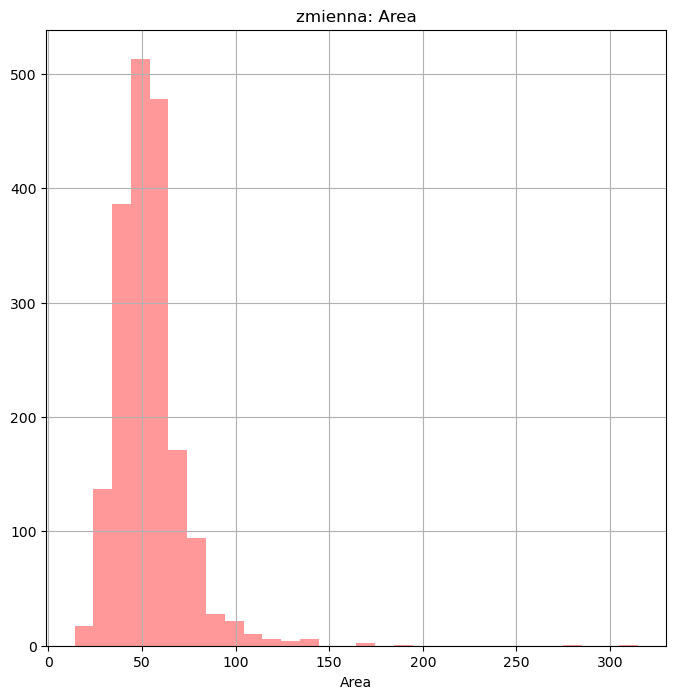

In [25]:
plt.figure(figsize=(8,8))
sns.distplot(df_without_duplicates['Area'], bins=30, kde=False, color='red')
plt.ticklabel_format(style='plain', axis='x')
plt.title(f'zmienna: Area')
plt.grid()

In [26]:
df_without_duplicates[df_without_duplicates['Area'] > 150]

,lang,id,relativeUrl,publicId,market,advertiserType,title,description,url,slug,createdAt,modifiedAt,features,MarketType,Area,Build_year,Building_floors_num,Country,City,City_id,Construction_status,Extras_types,Floor_no,ProperType,Province,Rooms_num,Security_types,Price,Price_per_m,hidePrice,latitude,longitude,street_id,street_name,district_id,city_id,city_name,province_id,province_name,feat_zmywarka,feat_telewizor,feat_teren zamknięty,feat_piekarnik,feat_telewizja kablowa,feat_pom. użytkowe,feat_internet,feat_ogródek,feat_taras,feat_lodówka,feat_drzwi / okna antywłamaniowe,feat_winda,feat_telefon,feat_balkon,feat_system alarmowy,feat_monitoring_ochrona,feat_rolety antywłamaniowe,feat_pralka,feat_klimatyzacja,feat_piwnica,feat_kuchenka,feat_dwupoziomowe,feat_domofon / wideofon,feat_meble,feat_garaż/miejsce parkingowe,feat_oddzielna kuchnia,n_features,PriceRange_min,PriceRange_max,district_name
1080,pl,64683210,/pl/oferta/duzy-dwupoziomowy-apartament-dla-wy...,4np3A,SECONDARY,business,"Duży, dwupoziomowy apartament dla wymagających","<p>Na sprzedaż wyjątkowy, dwupoziomowy apartam...",https://www.otodom.pl/pl/oferta/duzy-dwupoziom...,duzy-dwupoziomowy-apartament-dla-wymagajacych-...,2023-10-05,2024-02-02,"[monitoring / ochrona, garaż/miejsce parkingowe]",secondary,169.0,2022.0,2.0,Polska,bialystok,204,to_completion,garage,0.0,mieszkanie,podlaskie,4.0,monitoring,1424000.0,8426.0,0,53.117491,23.18289,170639,170639,5421,204,204,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,1000001,3000000,Mickiewicza
1176,pl,64771318,/pl/oferta/zyj-i-pracuj-w-domu-pelnym-mozliwos...,4nLYG,SECONDARY,business,Żyj i Pracuj w Domu Pełnym Możliwości? Sprawdź...,<p><strong>Dom z Możliwościami Działalności Go...,https://www.otodom.pl/pl/oferta/zyj-i-pracuj-w...,zyj-i-pracuj-w-domu-pelnym-mozliwosci-sprawdz-...,2023-11-02,2024-01-31,"[meble, balkon, garaż/miejsce parkingowe, taras]",secondary,315.0,1985.0,4.0,Polska,bialystok,204,ready_to_use,"balcony,garage,terrace",4.0,mieszkanie,podlaskie,8.0,,1499999.0,4762.0,0,53.145650,23.19813,103946,103946,4945,204,204,10,10,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,4,1000001,3000000,Wygoda
1466,pl,62942670,/pl/oferta/mieszkanie-280-m-bialystok-ID4g6gm,4g6gm,PRIMARY,business,"Mieszkanie, 280 m², Białystok",<p>****** KOMPLEKS MIESZKAŃ *******<br/>Zapras...,https://www.otodom.pl/pl/oferta/mieszkanie-280...,mieszkanie-280-m-bialystok-ID4g6gm,2022-04-01,2024-01-21,[],primary,280.0,2017.0,2.0,Polska,bialystok,204,to_completion,,1.0,mieszkanie,podlaskie,3.0,,1500000.0,5357.0,0,53.144380,23.14935,NaN,NaN,1746,204,204,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000001,3000000,Białostoczek
1644,pl,51760556,/pl/oferta/bezposrednio-szeregowka-bialystok-I...,3wbhG,PRIMARY,private,Bezpośrednio szeregówka Białystok,<p></p>\r\n<p>Sprzedam budynek mieszkalny w za...,https://www.otodom.pl/pl/oferta/bezposrednio-s...,bezposrednio-szeregowka-bialystok-ID3wbhG,2017-12-23,2024-02-24,"[garaż/miejsce parkingowe, ogródek]",primary,188.0,2023.0,2.0,Polska,bialystok,204,to_completion,"garage,garden",NaN,mieszkanie,podlaskie,6.0,,699000.0,3718.0,0,53.108529,23.07425,,,NaN,204,204,10,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,500001,750000,nan
1833,pl,64668446,/pl/oferta/apartament-136-m2-33-m2-garaz-ID4nlds,4nlds,PRIMARY,private,Apartament 136 m2+33 m2 Garaż,<p>Na sprzedaż apartament 2 poziomowy o powi...,https://www.otodom.pl/pl/oferta/apartament-136...,apartament-136-m2-33-m2-garaz-ID4nlds,2023-10-02,2024-02-08,"[internet, system alarmowy, teren zamknięty, d...",primary,169.0,2022.0,2.0,Polska,bialystok,204,to_completion,"garage,garden,terrace,two_storey,usable_room",0.0,mieszkanie,podlaskie,5.0,"alarm,closed_area,entryphone,monitoring",1424000.0,8426.0,0,53.124170,23.17278,170639,170639,5421,204,204,10,10,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,10,1000001,3000000,Mickiewicza


Mieszkania powierzchni powyzej 150 metrów wyglądają na poprawnie dodane. Z opisu ogłoszeń wynika, że są to albo bardzo duże apartamenty lub szeregówki skategoryzowane przez serwis Oto Dom jako mieszkania.
Powinny zostać w analizowanym zbiorze danych bez dalszych ingerencji.

Warto zwrócić uwagę na zmienne dotyczącej ceny za mieszkanie: ceny za całość oraz ceny za metr kwadratowy. <br>
W przypadku zmiennej ceny całkowitej na histogramie widać wartości zbliżające się do zera, co wydaje się nienaturalnym zjawiskiem.
Podobnie w przypadku ceny za metr kwadratowy (wcześniejsze kroki analizy pokazały, że w wyniku błędu w dodawaniu ogloszenia bądź niechęci ogłoszeniodawcy dodawania takich informacji w informacji o cenie za metr kwadratowy znajdują się wartości '1' - zjawisko te należy zweryfikować)

Analizując dalej zmienne numeryczne warto zwrócić uwagę na rozkład kwantyli oraz na wartości minimalne /maksymalne zmiennych - dalsza analiza wartości odstających.

- mieszkanie o powierzchni 14 metrów kwadratowych
- ogłoszenie z ceną za mieszkanie 17 K (cena za matr kwadratowy 714 zł)
- w przypadku liczby pięter budynków oraz piętra na którym znajduje się sprzedawane mieszkanie nie budzie żadnych wątpliwości
- podobnie rok powstania budynku. Białystok to miasto zniszczone w dużej mierze w trakcie działań wojennych z okresu II Wojny Światowej wiec nie zaskakuje budownictwo z drugiej połowy XX wieku i późniejsze. Natomiast ogłoszenia dotyczące starszych budowli znajdują się w historycznych dzielnicach miasta, które przetrwały okres II Wojny Światowej. Nie jest ich też dużo - 3 budowle wybudowane przed 1950 rokiem 

In [27]:
df_without_duplicates['price_k_pln'] = df_without_duplicates["Price"]/1000.0
df_without_duplicates[['Area', 'price_k_pln', 'Price_per_m', 'Building_floors_num','Floor_no', 'Build_year']].describe().round()

,Area,price_k_pln,Price_per_m,Building_floors_num,Floor_no,Build_year
count,1877.0,1803.0,1803.0,1762.0,1840.0,1350.0
mean,54.0,507.0,9509.0,5.0,3.0,2002.0
std,19.0,194.0,2425.0,3.0,2.0,23.0
min,14.0,17.0,714.0,1.0,-1.0,1884.0
25%,43.0,388.0,7904.0,3.0,1.0,1981.0
50%,51.0,472.0,9150.0,4.0,2.0,2010.0
75%,61.0,584.0,11021.0,5.0,3.0,2023.0
max,315.0,2155.0,20090.0,18.0,11.0,2025.0


Ogłoszenie które charakterzuje się najmniejszymi wartościami dla powierzchni, ceny oraz ceny za metr kwadratowy to ogłoszenie dotyczące sprzedaży udziałów w mieszkaniu. Wygląda poprawnie i powinno zostać w zbiorze danych.

In [28]:
df_without_duplicates[df_without_duplicates['Price'] < 18000]

,lang,id,relativeUrl,publicId,market,advertiserType,title,description,url,slug,createdAt,modifiedAt,features,MarketType,Area,Build_year,Building_floors_num,Country,City,City_id,Construction_status,Extras_types,Floor_no,ProperType,Province,Rooms_num,Security_types,Price,Price_per_m,hidePrice,latitude,longitude,street_id,street_name,district_id,city_id,city_name,province_id,province_name,feat_zmywarka,feat_telewizor,feat_teren zamknięty,feat_piekarnik,feat_telewizja kablowa,feat_pom. użytkowe,feat_internet,feat_ogródek,feat_taras,feat_lodówka,feat_drzwi / okna antywłamaniowe,feat_winda,feat_telefon,feat_balkon,feat_system alarmowy,feat_monitoring_ochrona,feat_rolety antywłamaniowe,feat_pralka,feat_klimatyzacja,feat_piwnica,feat_kuchenka,feat_dwupoziomowe,feat_domofon / wideofon,feat_meble,feat_garaż/miejsce parkingowe,feat_oddzielna kuchnia,n_features,PriceRange_min,PriceRange_max,district_name,price_k_pln
660,pl,64976231,/pl/oferta/udzial-w-wysokosci-1-3-w-lokalu-mie...,4oDhJ,SECONDARY,private,Udział w wysokości 1/3 w lokalu mieszkalnym,<p> <em> </em></p>\r\n<p> <em> <strong>WAR...,https://www.otodom.pl/pl/oferta/udzial-w-wysok...,udzial-w-wysokosci-1-3-w-lokalu-mieszkalnym-ID...,2024-01-10,2024-01-15,[],secondary,23.85,NaN,NaN,Polska,bielsk-podlaski,1242,,,NaN,mieszkanie,podlaskie,1.0,,17018.0,714.0,0,52.792789,23.185072,NaN,NaN,NaN,1242,1242,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10001,20000,outside,17.018


### 2.5 Przygotowanie dodatkowych zmiennych


W zbiorze danych występują zmienne kategoryczne, które należałoby przekształcić na zmienne 0-1 przed poddaniem ich dalszej analizie

**Zakodowanie zmiennych kategorycznych:**

In [29]:
dummy_construction_status = pd.get_dummies(df_without_duplicates['Construction_status'], prefix='construction').drop('construction_', axis=1)
df_without_duplicates = pd.concat([df_without_duplicates, dummy_construction_status], axis=1)
dummy_advertiserType = pd.get_dummies(df_without_duplicates['advertiserType'], prefix='advertiser')
df_without_duplicates = pd.concat([df_without_duplicates, dummy_advertiserType], axis=1)
dummy_MerketType = pd.get_dummies(df_without_duplicates['MarketType'], prefix='MerketType')
df_without_duplicates = pd.concat([df_without_duplicates, dummy_MerketType], axis=1)
dummy_district = pd.get_dummies(df_without_duplicates['district_name'], prefix='district')
df_without_duplicates = pd.concat([df_without_duplicates, dummy_district], axis=1)

In [30]:
df_without_duplicates['if_bialystok'] = [1 if x == 'bialystok' else 0 for x in df_without_duplicates['City']]

## 3. Analiza ogłoszeń sprzedaży mieszkań w Białymstoku

### 3.1 Charakterystyka ogłoszeń z względu na zmienne numeryczne

Ogólna charakterystyka badanych ofert sprzedaży mieszkań z względu na cenę za metr kwadratowy, powierzchnie mieszkania, rok wybudowania budynku oraz wysokość budynku, w którym znajduje się mieszkanie na sprzedaż.

In [63]:
num_var_to_compare = ['Area', 'Build_year', 'Building_floors_num', 'Floor_no', 'Rooms_num', 'Price_per_m', 'n_features']

count_groups = (
    df_without_duplicates[num_var_to_compare]
    .describe()
    .round()
    .fillna(-1)
    .astype('int')
    .reset_index()

)
display(count_groups)

,index,Area,Build_year,Building_floors_num,Floor_no,Rooms_num,Price_per_m,n_features
0,count,1877,1877,1762,1877,1877,1877,1877
1,mean,54,2002,5,3,3,9519,6
2,std,19,19,3,2,1,2377,4
3,min,14,1884,1,-1,0,714,0
4,25%,43,1991,3,1,2,7950,3
5,50%,51,2002,4,2,3,9348,5
6,75%,61,2021,5,4,3,10970,9
7,max,315,2025,18,11,8,20090,22


- w analziowanym zbiorze danych przeciętna cena za metr kwaratowy sprzedawanego mieszkania to 9.5 tysięcy złotych. IQR (rozstęp międzykwartylowy) mieści się w granicach między około 8 tysięcy złotych za metr do 10 tysięcy złotycych (50% wszystkich badanych mieszkań mieści się tych widełkach cenowych). Najdroższe mieszkanie wśród oferowanych na sprzedaż mieszkań, któe zostały poddane badaniu to 20 tysięcy złotych za metr kwadratowy.
- przeciętna wielkość mieszkań na sprzedaż, które zostąły objęte badaniem to 54 metry kwadratowe (IQR pmiędzy 43 a 61 metrów). Można to uznać za standardowią wielkosć mieszkania występującą na rynku nieruchomości w Białymstoku. Natomiast przeciętna liczba pokoi w takim mieszkaniu to 3. 
- Białystok charakteryzuje się stosunkowo nową zabudową. Przeciętny wiek oferowanego mieszkania to 22 lata. Natomiast warto zwrócić uwagę, że około 25 % wszystich mieszkań powstało w ciągu ostatnich 3 lat (ostatni kwartyl).
- Białystok charakteryzuje się również stosunkowo niską zabudową. Przeciętny blok, w którym znajduje się mieszkanie na sprzedaż ma 5 pięter, a samo mieszkanue znajduje się zazwyczaj na 3 piętrze.


### 3.2 Charakterystyka przeciętnej ceny mieszkania z względu na zmienne kategoryczne

W poniższej części zostanie przeanalizowany związek ceny mieszkania (cena za metr kwadratowy) w zależności od zmiennych kategorycznych tj. typ rynku (mieszkanie z rynku pierwotnego czy wtórnego), status ogłoszeniodawcy (ogłoszenie sprzedaży mieszkania wystawione przez firmę - biznes, czy przez osobęprywatną), status nieruchomości (gotowe do wprowadzenia, do remontu lub do generalnego remontu) oraz miejsce w którym znajduje się dane mieszkanie (mmiejscowość jeżeli wystawione mieszkanie jest spoza granic białegostoku) lub dzielnica miasta.

In [31]:
cat_var_to_explore = ['MarketType', 'advertiserType',  'Construction_status', 'City', 'district_name']

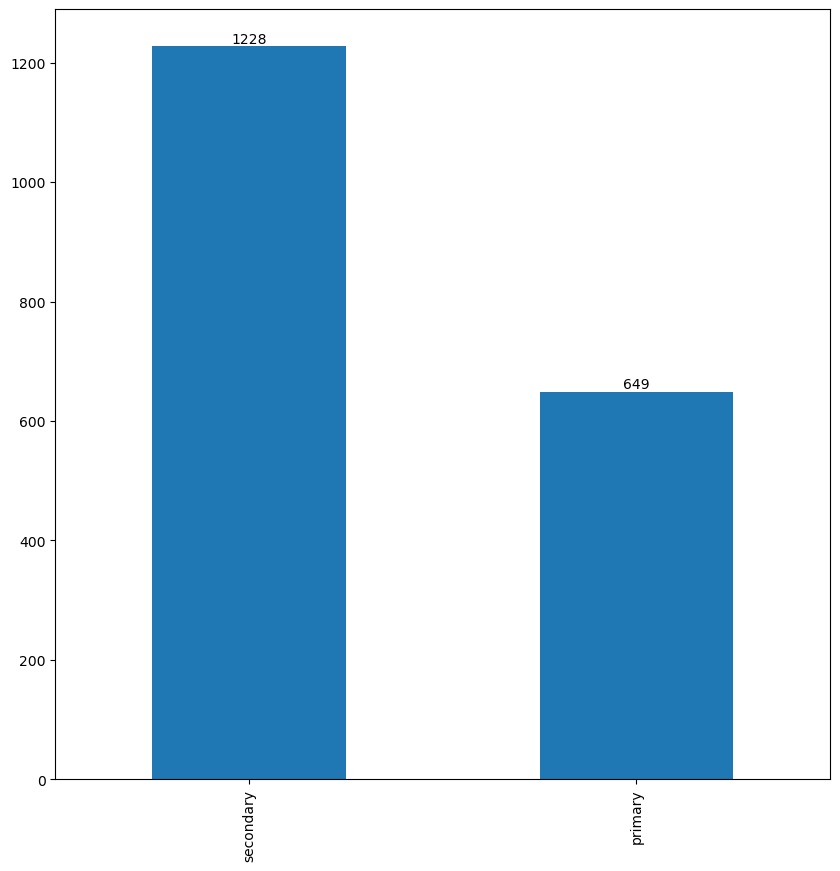

,MarketType,n_ads,mean_price_m2,mean_area,mean_year,mean_build_floor_num,mean_n_features,perc_share
1,secondary,1228,9662,54,1994,5,6,0.65
0,primary,649,9183,55,2023,4,6,0.35


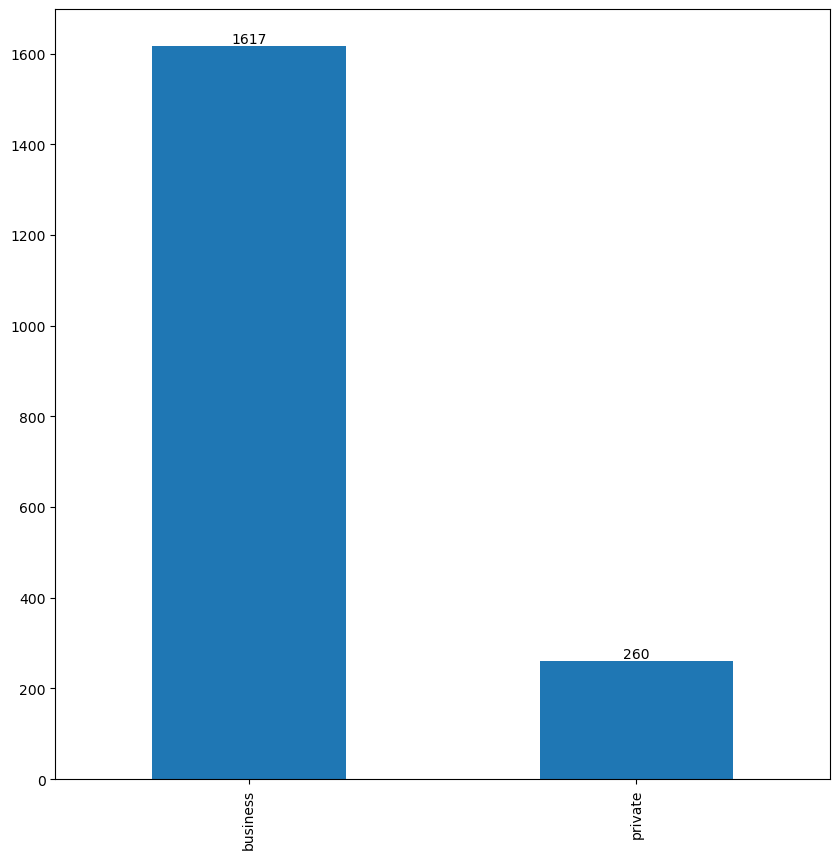

,advertiserType,n_ads,mean_price_m2,mean_area,mean_year,mean_build_floor_num,mean_n_features,perc_share
1,private,260,10358,53,2002,5,9,0.14
0,business,1617,9366,54,2001,5,5,0.86


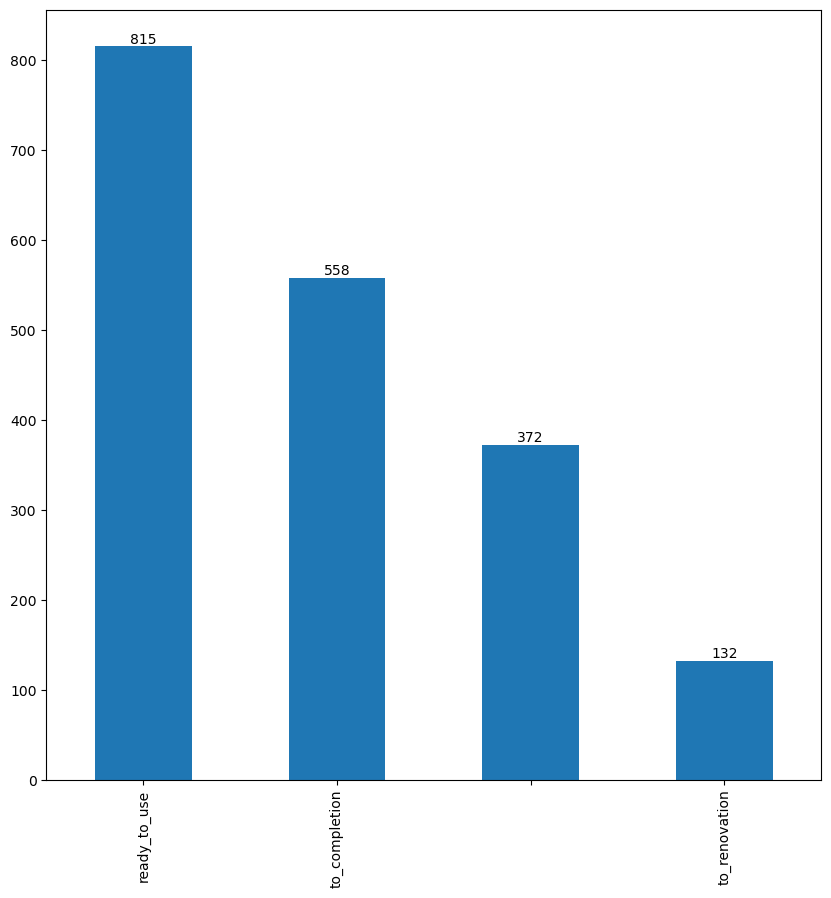

,Construction_status,n_ads,mean_price_m2,mean_area,mean_year,mean_build_floor_num,mean_n_features,perc_share
1,ready_to_use,815,10414,54,1999,5,7,0.43
0,,372,9252,54,2001,5,3,0.20
2,to_completion,558,8784,55,2018,4,6,0.30
3,to_renovation,132,7308,51,1977,5,4,0.07


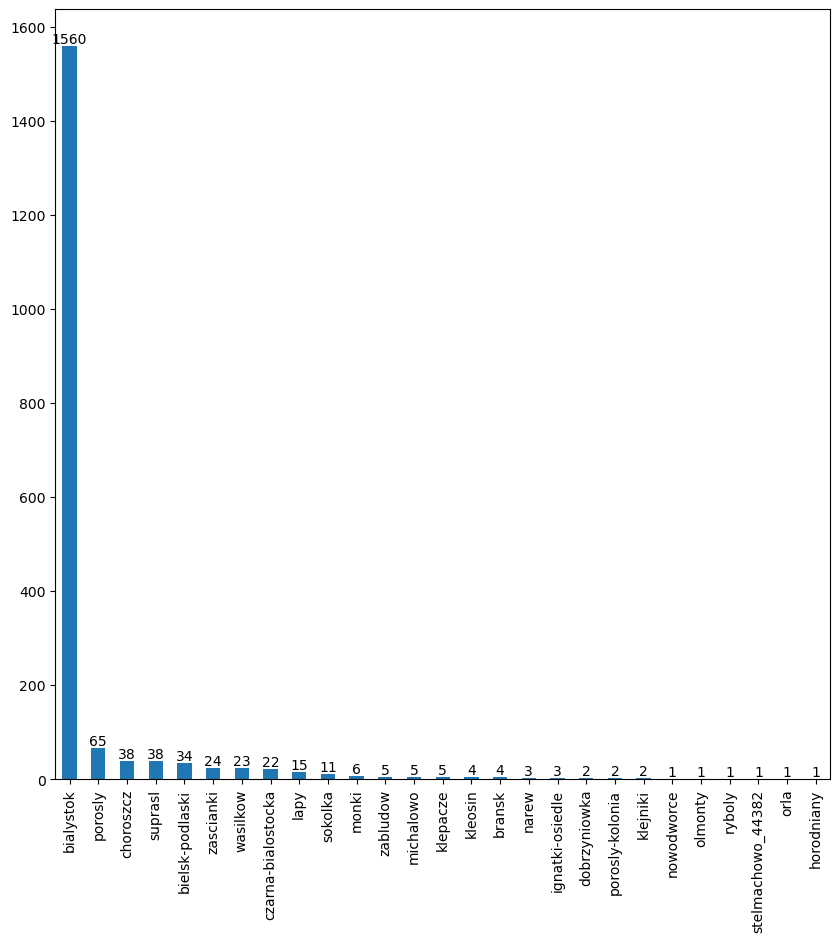

,City,n_ads,mean_price_m2,mean_area,mean_year,mean_build_floor_num,mean_n_features,perc_share
6,horodniany,1,12500,69,2021,3,18,0.00
0,bialystok,1560,9984,54,2001,5,6,0.83
24,wasilkow,23,9133,55,2009,3,5,0.01
7,ignatki-osiedle,3,8997,53,2006,3,7,0.00
26,zascianki,24,8567,63,2024,3,3,0.01
9,kleosin,4,8460,51,2006,3,6,0.00
18,porosly,65,7978,57,2025,3,5,0.03
15,nowodworce,1,7609,46,2023,3,11,0.00
19,porosly-kolonia,2,7470,56,2024,1,0,0.00
3,choroszcz,38,7166,58,2000,4,5,0.02


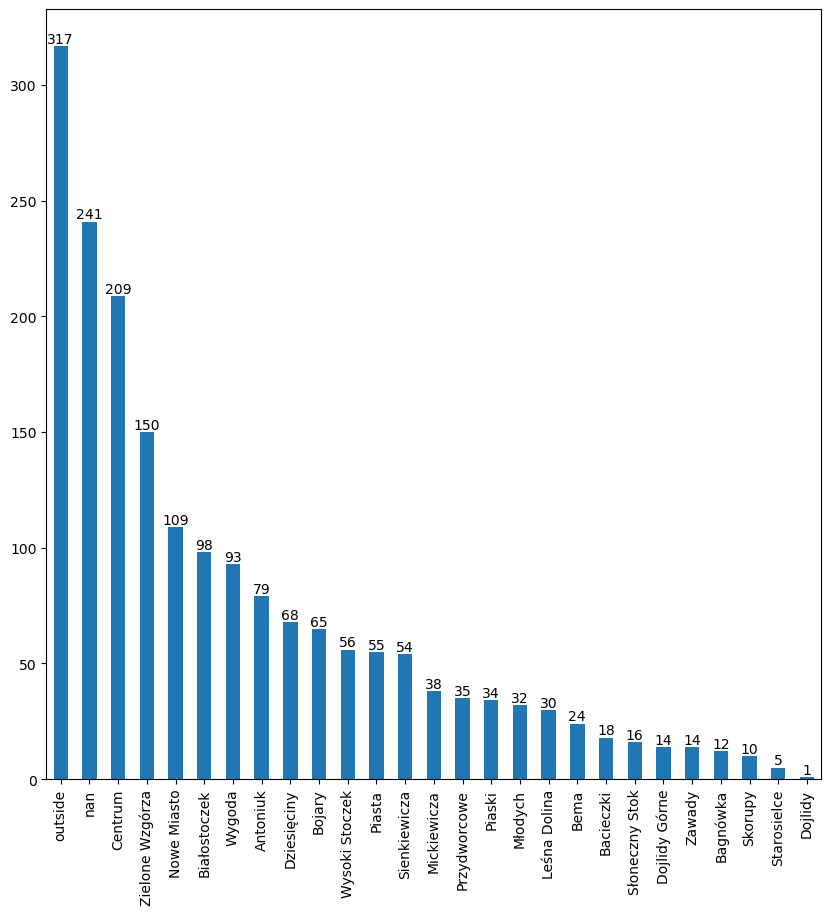

,district_name,n_ads,mean_price_m2,mean_area,mean_year,mean_build_floor_num,mean_n_features,perc_share
7,Dojlidy,1,13560,78,2021,2,15,0.00
16,Przydworcowe,35,12057,60,2005,5,7,0.02
4,Białostoczek,98,11389,54,2012,7,6,0.05
6,Centrum,209,11177,49,1997,6,5,0.11
5,Bojary,65,10993,56,2002,6,7,0.03
14,Piaski,34,10761,51,1989,8,6,0.02
17,Sienkiewicza,54,10688,49,1993,6,6,0.03
25,nan,241,10155,52,1999,5,5,0.13
0,Antoniuk,79,9909,48,1994,6,5,0.04
13,Nowe Miasto,109,9872,63,2004,5,7,0.06


In [32]:
for i in cat_var_to_explore:
    ax = (
        df_without_duplicates[i]
        .value_counts()
        .sort_values(ascending=False)
        .plot(kind='bar', figsize=(10,10), grid=False)
    )
    ax.bar_label(ax.containers[0])
    plt.show()
    
    sum_df = (
        df_without_duplicates
        .groupby(i)
        .agg(
            n_ads= ('id', 'size'), 
            mean_price_m2= ('Price_per_m', 'mean'), 
            mean_area = ('Area', 'mean'), 
            mean_year = ('Build_year', 'mean'),
            mean_build_floor_num = ('Building_floors_num', 'mean'),
            mean_n_features = ('n_features', 'mean')
        )
        .round()
        .fillna(-1)
        .astype('int')
        .reset_index()
        .sort_values(ascending=False, by ='n_ads')
    )
    sum_df['perc_share'] = round(sum_df['n_ads'] / df_without_duplicates.shape[0], 2)
    display(sum_df)
    

#### 3.2.1 Typ rynku - rynek pierwotny vs. rynek wtórny
- najwięcej mieszkań na sprzedaż pochodzi z rynku wtórnego
- cena mieszkań za metr kwadratowy z rynku wtórnego jest przeciętnie wyższa o około 500 zł za metr kwadratowy
- brak znaczącej różnicy pomiędzy rynkiem pierwotnym a wtórnym jeżęli chodzi o przeciętną powierzchnię sprzedawanego mieszkania. Jest to 54-55 metrów kwadratowych. 
- naturalnie - mieszkania z rynku wtórnego są starsze. Przeciętny wiek wystawionego mieszkania z rynku wtórnego to około 30 lat (budynek wybudowany w roku 1994)

#### 3.2.2 Status ogłoszeniodawcy - typ podmiotu wystawiającego ogłoszenie (firma vs. osoba prywatna)
- zdecydowana większość ogłoszeń jest wystawiana przez firmy (86% wszystkich ogłoszeń)
- przeciętna cena za metr kwadratowy wystawionego mieszkania przez osobę prywatną jest o około 700 zł wyższa, niż przez firmę
- piwierzchnia wystawionych mieszkań jest porównywalna - jest to przeciętnie 53-54 metrów kwadratowych
- rok budowy budywnku jest porównywalny. Blok w którym znajduje się wystawione mieszkanie na sprzedaż pochodzi z początku XXI wieku i ma około 20 lat

#### 3.2.3 Status mieszkania
- status mieszkania można podzielić na 3 kategorie: gotowe do wprowadzenia (ready to use), do wykończenia (to_completion) lub do remontu (to_renovation). Natomiast około 20% badanych ogłoszeń nie ma określonego statusu mieszkania
- najwięcej mieszkań w analizowanym zbiorze danych ma status gotowych do wprowadzenia (43%). Są to również mieszkania najdroższe (przeciętnie o około 1 000 zł więcej niż kategoria do wykończenia lub ponad 2 500 zł więcej niż mieszkania do remontu). 
- mieszkania do wykończenia są najmłodsze (przeciętny wiek takiego mieszkania to 6 lat). Są to zapewne mieszkania z rynku wtórnego, które ktoś już kupił i aktualnie szuka czegoś nowego. Nie są więc to mieszkania zniszczone, ale używane i w nowym budownictwie. Mogą to być również ostatnie mieszkania z gotowych już nowowybudowanych bloków, które się jeszcze nie sprzedały.
- przeciętnie najstarsze są mieszkania do kompletnego remontu (przeciętny wiek takiego mieszkania to około 47 lat). Mimo, iż są to mieszkania najtańsze, to warto mieć na uwadzę, że dodatkowy koszt takiego mieszkania to wykonanie generalnego remontu.

#### 3.2.4 Miejscowość

##### 3.2.4.1 Liczba ogłoszeń
- najwięcjej mieszkań na sprzedaż w analizowanym zbiorze danych miejści się w granicach administracyjnych miasta Białystok
- drugie pod kątem liczby mieskań na sprzedaż są Porosły - miejscowość leżąca niedaleko granic Białegostoku, przy drodze wyjazdowej do Warszawy (S8). Jest to aktualnie miejsce, w którym powstaje dużo nowych bloków.
- 3 miejsce zajmuje Choroszcz (podobnie jak Porosły, miejscowść znajduje się niedaleko Białęgostoku i jest zlokalizowana przy drodze wyjazdowej S8) oraz Supraśl (miejscowość uzdrowizkowa położona na skraju Puszczy Knyszyńskiej)
- pozostałe miejscowości, w których można znaleźć więcej niż 20 mieszkań na sprzedaż to miasteczka położone bliżej (Zaścianki, wasików - które granicząz Białymstokiem), lub dalej od miasta (Łapy, Bielks Podlaski, Czarna Białostocka) - ale w któych ewentualny dojazd do miasta jest stosunkowo łatwy.
- miejsca tj. Kleosion, Klepacze, Ignatki, Porosły-kolonia, Nowodworce, czy Horodniany to leżące niedaleko granic miasta miejscowości, w których dominuje zabudowa domów jednorodzinnych. Białystok znacznie rozwija się wkierunku drogi wyjazdowej na Warszawę, te miejsca leżą dalej od drogi S8 i stąd może wynikać efekt mniejszego zainteresowania.

##### 3.2.4.2 Cena
- Przeciętnie najdroższe są mieszkania położone w granicach admistracyjnych miasta Białystok - prawie 10 000 zł za metr kwadratowy
- szukając mieszkania do zakupy - można zwrócić uwagę na bloki znajdujące się poza Białymstokiem w których mieszkania są znacznie tańsze. W Porosłach przeciętna cena za metr kwadratowy jest 2 tysiące tańsza. W Supraślu i Choroszczy - które są bardziej oddalone potencjalny nabywca przeciętnie zapłąci mniej o 3-3.5 tysiąca złotych mniej niż za podobne mieszkanie w Białymstoku.
- Można zauważyć, że im dana miejscowość leży bliżej miasta Białystok - cena za metr kwadratowy wzrasta (np. Wasilków który można uznać już prawie za jedną z dzielnic miasta - przeciętna cena za metr kwadratowy jest niższa o tysiąc złotcyh niż w samym Białymstoku)

##### 3.2.4.3 Powierzchnia oraz rok budowy
- pod względem przeciętnej powierzchni oferowanych mieszkań na sprzedaż poszczególne miejscowości nie różnią się w znaczący sposó od siebie - szczególnie Białystok i mieszkania na sprzedaż w miejscowościach graniczących, bądź leżących niedaleko Białegostoku (około 55 metrów kwadratowych)
- przeciętnie nieco większe mieszkania na sprzedaż znajdują się w Choroszczy (58 metrów kwadratowych) oraz w Zaściankach (63 metry kwadratowe)
- natomiast największe mieszkania można znaleźć w miejscowościach w któych dominuje zabudowa domów jednorodzinnych. Można stąd wnioskować, że są to oferty szeregówek (które charakteryzują się większą powierzchnią niż mieszkania w blokach, ale przez serwis Oto Dom bądź ogłoszeniodawców są kategoryzowane jako mieszkania)
- sam Białystok charakteryzuje się stosunkowo młodymi mieszkaniami na sprzedaż (wiek przeciętnego mieszkania na sprzedaż to 23 lata)
- w Porosły, Zaścianki, Klepacze - to miejscowości w których budownictwo mieszkalne dopiero zaczyna powstawać. Wiek przeciętnego mieszkania na sprzedaż to 1 rok (tzw. nowe budownictwo).
- bloki poza Białymstokiem charakteryzują się taże niższą wysokością. Przeciętna wysokość budynku w samym Białymstoku to 5 pięter, natomaist poza miastem takie budynki już nie występują.

#### 3.2.5 Dzielnica miasta

##### 3.2.5.1  Liczba ogłoszeń
- warto jeszcze zwrócić uwagęna dzielnicę miasta w której znajduje się sprzedawane mieszkanie. Kategorią "outside" zostały oznaczone mieszkania znajdujące się poza Białymstokiem
- dużągrupę ogłoszeń stanowią te, w których ogłoszeniodawca nie podał nazwy dzielnicy w której znajduje się oferowane mieszkanie na sprzedaż (13% wszystkich ogłoszeń).
- procentowo najwięcej mieszkań na sprzedaż znajduje się poza miastem i są one najtańsze
- pod kątem liczby mieszkań na sprzedaż najbardziej popularne dzielnice to: Centrum, Zielone Wzgórza, Nowe Miasto, Białostoczek, Wygoda, Antoniuk, Dziesięciny. Są to dzielnice w których dominuje zabudowa mieszkaniowa (dominują bloki)
- podobne dzielnice to: Wysoki Stoczek, Piata, Piaski, Sienkiwicza, Mickiewicza, Przydworcowe

##### 3.2.5.2 Cena
- najtańsze mieszkania można znaleźć poza granicami miasta. Natomiast najdroższe dzielnic to: Przydwrcowe (około 12K za metr kwadratowy), Białostoczek, Centrum (przeciętnie około 11 K za metr kwadratowy)
- osiedle przydworcowe może charakteryzować się wyższą niż przeciętna ceną za metr kwadratowy z względu na swoje położenie - blikso dworca a dodatkow oblisko węzłów komunikacyjnych takich jak dworzec PKP i PKS.
- Dojlidy - 13.5 K za metr kwadratowy, jednakże jest to osiedle domków jednorodzinnych. Warto zwrócić uwagę na stosunkowo dużą powierzchnię mieszkania. Jest to zapewne oferta mieszkania w szeregówce. Dodatkowo Dojlidy Górne charakteryzują się bardziej prestiżową zabudową niż pozostałe regiony miasta
- Osiedla takie jak Bojary, Piaski, Sienkiwicza - charakteryzują się przeciętną ceną około 10 K za metr kwadratowy. Są to osiedla położone bardzo blisko centrum miasta.
- poniżej 10 tysięcy za metr kwadratowy można zapłącić na osiedlach takich jak: Antoniuk, Nowe Miasto, Bema, Zawady, Młodych, Mickiewicza, Wysoki Stoczek, Piasta, Dziesięciny, Zielone Wzgórza. Są to osiedla nieco oddalone o centrum miasta (z wyjątkiem Mickiewicz, Bema i Piasta) - ale w przypadku tych osiedli są to mieszkania w zabudowie zdecydowanie starszei i są to prawdopodobnie mieszkania przynajmniej do remontu lub do renowacji - które to charakteryzują się przeciętnie niższą ceną za metr kwadratowy. Potencjalny nabwyca jednak musi mieć na uwadze dodatkowe koszta dotyczące odświeżenia, bądź wyremontowania mieszkania.
- Dojlidy Górne charakteryzują sie stosunkowo nową zabudową, przeciętnie niższą ceną oraz przeciętnie wiekszą powierzchnią oferowanych mieszkań na sprzedaż. Dzielnica ta jest miejsceom głównie o zabudowie złożonej z domów. Wniosek stąd że są to głównie oferty mieszkań  szeregówkach i to niedawno wybudowanych (przeciętny wiek oferowanego mieszkania to 1 rok). Może to być ciekawe rozwiązanie dla osób, które są zainteresowane mieszkaniem dalej od centrum miasta (na uboczy z gorszą komunikacją miejską) ale zyskują tym większą powierzchnię oraz niżą przeciętnie ceną za metr kwadratowy.

### 3.2 Analiza przeciętnej ceny metra kwadratowego z względu na położenie oraz typ mieszkania

W poniższej części przeciętna cena metra kwadratowego oferowanego mieszkania na sprzedaż zostanie porównana z typem danego mieszkania (status rynku - pierwotny vs. wtórny), typ ogłoszeniodawcy (osoba prywatna vs. firma), status mieszkania (gotowe do wprowadzenia, do odświeżenia lub do remontu) do położenia mieszkania. 
W poprzedniej części zauważono, że znaczący wpływ na przeciętną cenę metra kwadratowego sprzedawanego mieszkania ma miejsce, w którym dane mieszkanie się znajduje. Pozostałę zmienne zostaną więc porównane do tej kategorii (zmienna if_bialystok, 1 - oznacza, że oferowane mieszkanie na sprzedaż znajduje się w granicach administracyjnych miasta, 0 - poza granicami).
Procentowy udział liczby ofert (perc_share) w tym przypadku jest wyliczany w ramach grupy if_bialystok (liczba ofert sprzedaży mieszkań znajdujących się w samym Białymstoku lub poza miastem).

In [33]:
check_diff_cat = ['MarketType', 'advertiserType', 'Construction_status']

In [58]:
for i in check_diff_cat:
    check_df = (
        df_without_duplicates
        .groupby([i, 'if_bialystok'])
        .agg(
            n_ads= ('id', 'size'),
            mean_price_m2= ('Price_per_m', 'mean'), 
            mean_area = ('Area', 'mean'),
            mean_year = ('Build_year', 'mean'))
        .round()
        .fillna(-1)
        .astype('int')
        .reset_index()
        .sort_values(by=['if_bialystok', 'n_ads'], ascending=False)
    )

    check_df['perc_share'] = check_df['n_ads'] / check_df.groupby('if_bialystok')['n_ads'].transform('sum')
    display(check_df)

,MarketType,if_bialystok,n_ads,mean_price_m2,mean_area,mean_year,perc_share
3,secondary,1,1075,10119,54,1996,0.69
1,primary,1,485,9667,55,2012,0.31
0,primary,0,164,8014,56,2015,0.52
2,secondary,0,153,6445,53,1995,0.48


,advertiserType,if_bialystok,n_ads,mean_price_m2,mean_area,mean_year,perc_share
1,business,1,1333,9816,54,2001,0.85
3,private,1,227,10933,52,2002,0.15
0,business,0,284,7356,55,2005,0.90
2,private,0,33,6396,55,2003,0.10


,Construction_status,if_bialystok,n_ads,mean_price_m2,mean_area,mean_year,perc_share
3,ready_to_use,1,732,10816,54,2000,0.47
5,to_completion,1,393,9244,55,2007,0.25
1,,1,335,9574,53,2002,0.21
7,to_renovation,1,100,8095,51,1982,0.06
4,to_completion,0,165,8119,55,2014,0.52
2,ready_to_use,0,83,6866,55,1997,0.26
0,,0,37,6365,56,2001,0.12
6,to_renovation,0,32,4850,52,1987,0.10


#### 3.2.1 Typ rynku, typ ogłoszeniodawcy, typ mieszkania

- najwięcej mieszkań na sprzedaż w Białymstoku można znaleźć z rynku wtórnego. Są to również przeciętnie najdroższe mieszkania (około 10 tysięcy złotych za metr kwadratowy). Warto zwrócić uwagę, że mieszkania z rynku wtórnego, które znajdują się poza granicami miasta należą do zdecydowanie tańszych (około 3.5 tysiąca złotych różnicy za metr kwadratowy)
- w Białymstoku w serwisie Oto Dom najwięcej ogłoszeń sprzedaży mieszkań wystawiają firmy. Warto jednak zwrócić uwagę, że oferty mieszkań wystawianych przez firmy, a a których są oferowane mieszkana znajdujące się w granicach miasta są tańsze niż te oferowane przez osoby prywatne. Odmienną sytuację można zaobserwować wśród ofert oferujących mieszkania znajdujące się poza granicami maista. Mimo, iż ogółem tańsze, to te wystawiane przez firmy są droższe o około 700 złza metr kwadratowy, niż te wystawiane przez osoby prywatne.
- mieszkania z statusem "gotowe do wprowadzenia" znajdujące się w granicach miasta stanowią najdroższą kategorię mieszkań (przeciętnie 10 tysięcy złotych za metr kwadratowy). Mieszkania do wykończenia lub do remontu są tańsze przeciętnie o odpowiendio tysiąc bądź dwa tysiące złotych mniej za metr kwadratowy.
- natomiast mieszkana z statusem "do wykończenia" ale znajdujące się poza miastem - stanowią najdroższą grupę mieszkań w tej kategorii. Mieszkani gotowe do wprowadzenia są tańsze o około tysiąc złotych w ramach mieszkań znajdujących się poza miastem, natomiast w porównaniu do mieszkań leżących w granicach Białegostoku - już o około 3 tysiące złotych. Natomiast wiek takiego mieszkania jest większy o około 3 lata (w porównaniu do mieszkań w mieście z statusem "ready_to_use").

#### 3.2.2 Typ rynku vs. typ ogłoszeniodawcy z wzglęu na położenie mieszkania na sprzedaż



In [35]:
check_df = (
    df_without_duplicates
    .groupby(['MarketType', 'advertiserType', 'if_bialystok'])
    .agg(n_ads= ('id', 'size'), mean_price_m2= ('Price_per_m', 'mean'))
    .round()
    .fillna(-1)
    .astype('int')
    .reset_index()
    .sort_values(by=['if_bialystok', 'n_ads'], ascending=False)
)

check_df['perc_share'] = check_df['n_ads'] / check_df.groupby('if_bialystok')['n_ads'].transform('sum')
display(check_df)

,MarketType,advertiserType,if_bialystok,n_ads,mean_price_m2,perc_share
5,secondary,business,1,888,9962,0.569231
1,primary,business,1,445,9502,0.285256
7,secondary,private,1,187,10865,0.119872
3,primary,private,1,40,11251,0.025641
0,primary,business,0,155,7589,0.488959
4,secondary,business,0,129,6469,0.406940
6,secondary,private,0,24,6315,0.075710
2,primary,private,0,9,6612,0.028391


In [36]:
check_df = (
    df_without_duplicates
    .groupby(['MarketType', 'Construction_status', 'if_bialystok'])
    .agg(n_ads= ('id', 'size'), mean_price_m2= ('Price_per_m', 'mean'), mean_area = ('Area', 'mean'))
    .round()
    .fillna(-1)
    .astype('int')
    .reset_index()
    .sort_values(by=['if_bialystok','Construction_status', 'MarketType'  ,'n_ads'], ascending=False)
)

check_df['perc_share'] = check_df['n_ads'] / check_df.groupby('if_bialystok')['n_ads'].transform('sum')
# display(check_df[check_df['if_bialystok'] == 0])
display(check_df.reset_index(drop=True))

,MarketType,Construction_status,if_bialystok,n_ads,mean_price_m2,mean_area,perc_share
0,secondary,to_renovation,1,98,8086,51,0.062821
1,primary,to_renovation,1,2,8506,70,0.001282
2,secondary,to_completion,1,51,9320,53,0.032692
3,primary,to_completion,1,342,9170,55,0.219231
4,secondary,ready_to_use,1,671,10644,54,0.430128
5,primary,ready_to_use,1,61,12710,49,0.039103
6,secondary,,1,255,9681,53,0.163462
7,primary,,1,80,9220,55,0.051282
8,secondary,to_renovation,0,31,4845,52,0.097792
9,primary,to_renovation,0,1,5000,60,0.003155


In [38]:
(
    df_without_duplicates[['Area', 'Price_per_m', 'Build_year', 'Building_floors_num', 'Floor_no', 'Rooms_num' ]]
    .groupby(
        pd.cut(df_without_duplicates['Area'], 
               np.percentile(df_without_duplicates['Area'], [0, 25, 75, 100]), include_lowest=True))
    .mean()
    .round()
    .astype('int')
)

,Area,Price_per_m,Build_year,Building_floors_num,Floor_no,Rooms_num
Area,,,,,,
"(13.999, 42.62]",36,10453,2004,5,3,2
"(42.62, 61.3]",52,9363,1996,5,3,3
"(61.3, 315.0]",76,8921,2009,4,2,4


In [39]:
(
    df_without_duplicates[['Area', 'Price_per_m', 'Build_year', 'Building_floors_num', 'Floor_no', 'Rooms_num', 'if_bialystok']]
    .groupby(
        [pd.cut(df_without_duplicates['Area'], 
               np.percentile(df_without_duplicates['Area'], [0, 25, 75, 100]), include_lowest=True), 
         'if_bialystok']
    )
    .mean()
    .round()
    .astype('int')
)

Area  Price_per_m  Build_year  \
Area            if_bialystok                                  
(13.999, 42.62] 0               37         6863        2001   
                1               36        11039        2004   
(42.62, 61.3]   0               53         6936        2004   
                1               52         9819        1994   
(61.3, 315.0]   0               75         6987        2014   
                1               77         9304        2008   

                              Building_floors_num  Floor_no  Rooms_num  
Area            if_bialystok                                            
(13.999, 42.62] 0                               3         2          2  
                1                               6         3          2  
(42.62, 61.3]   0                               3         1          3  
                1                               5         3          3  
(61.3, 315.0]   0                               3         1          4  
                1                               5         2          4

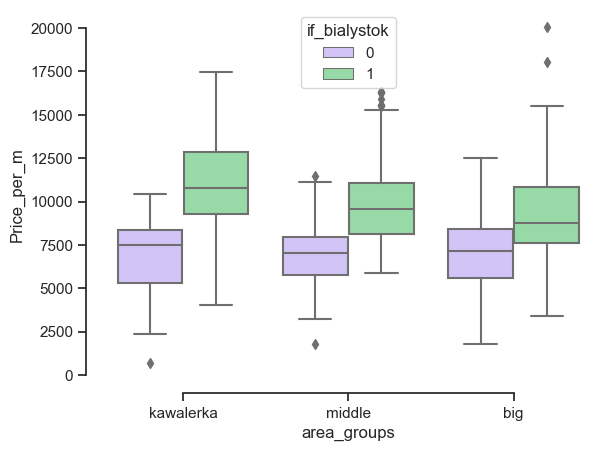

In [40]:
sns.set_theme(style="ticks", palette="pastel")

box_data = df_without_duplicates[['Area', 'Price_per_m', 'if_bialystok']]
box_data['area_groups'] = (
    pd.cut(
        df_without_duplicates['Area'], 
        np.percentile(df_without_duplicates['Area'], [0, 25, 75, 100]), 
        include_lowest=True,
        labels = ['kawalerka', 'middle', 'big']
    )
)

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="area_groups", y="Price_per_m",
            hue="if_bialystok", palette=["m", "g"],
            data=box_data)
sns.despine(offset=10, trim=True)

In [41]:
(
    df_without_duplicates[['Area', 'Price_per_m', 'Build_year', 'Building_floors_num', 'Floor_no', 'Rooms_num', 'district_name']]
    .groupby(
        [pd.cut(df_without_duplicates['Area'], 
               np.percentile(df_without_duplicates['Area'], [0, 25, 75, 100]), include_lowest=True), 
         'district_name']
    )
    .mean()
    .round()
    .fillna(-1)
    .astype('int')
)

Area  Price_per_m  Build_year  \
Area            district_name                                    
(13.999, 42.62] Antoniuk           35        10183        1988   
                Bacieczki          33         9665        2003   
                Bagnówka           -1           -1          -1   
                Bema               37        11100        2008   
                Białostoczek       39        12453        2013   
...                               ...          ...         ...   
(61.3, 315.0]   Wysoki Stoczek     74         9533        2008   
                Zawady             80         9550        2023   
                Zielone Wzgórza    71         7892        1992   
                nan                72         9308        2001   
                outside            75         6987        2014   

                                 Building_floors_num  Floor_no  Rooms_num  
Area            district_name                                              
(13.999, 42.62] Antoniuk                           5         3          2  
                Bacieczki                          3         3          1  
                Bagnówka                          -1        -1         -1  
                Bema                               6         3          2  
                Białostoczek                       6         4          2  
...                                              ...       ...        ...  
(61.3, 315.0]   Wysoki Stoczek                     6         3          3  
                Zawady                             2         1          4  
                Zielone Wzgórza                    4         2          4  
                nan                                4         3          3  
                outside                            3         1          4  

[81 rows x 6 columns]

In [42]:
for i in num_var_to_compare:
    print(f'grouped var is: if_bialystok & checked variable is: {i}')
    count_groups = (
        df_without_duplicates.groupby('if_bialystok')[i]
        .describe()
        .round()
        .fillna(-1)
        .astype('int')
        .reset_index()

    )
    display(count_groups)

grouped var is: if_bialystok & checked variable is: Area


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,317,55,16,14,43,53,62,133
1,1,1560,54,19,16,43,50,61,315


grouped var is: if_bialystok & checked variable is: Build_year


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,206,2007,22,1958,1985,2022,2025,2025
1,1,1144,2001,23,1884,1980,2008,2023,2025


grouped var is: if_bialystok & checked variable is: Building_floors_num


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,296,3,1,1,2,3,4,5
1,1,1466,5,3,1,4,4,6,18


grouped var is: if_bialystok & checked variable is: Floor_no


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,313,1,1,-1,0,1,2,4
1,1,1527,3,2,0,1,2,4,11


grouped var is: if_bialystok & checked variable is: Rooms_num


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,317,3,1,1,2,3,3,7
1,1,1560,3,1,0,2,3,3,8


grouped var is: if_bialystok & checked variable is: Price_per_m


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,281,6934,1798,714,5616,7093,8312,12500
1,1,1522,9984,2218,3427,8179,9842,11374,20090


grouped var is: if_bialystok & checked variable is: n_features


,if_bialystok,count,mean,std,min,25%,50%,75%,max
0,0,317,5,3,0,2,4,7,18
1,1,1560,6,4,0,3,5,10,22


In [43]:
for i in num_var_to_compare:
    print(f'grouped var is: district_name & checked variable is: {i}')
    count_groups = (
        df_without_duplicates.groupby('district_name')[i]
        .describe()
        .round()
        .fillna(-1)
        .astype('int')
        .reset_index()
        .sort_values(by='mean')

    )
    display(count_groups)

grouped var is: district_name & checked variable is: Area


,district_name,count,mean,std,min,25%,50%,75%,max
0,Antoniuk,79,48,16,26,37,46,54,114
6,Centrum,209,49,17,20,39,47,55,140
17,Sienkiewicza,54,49,13,23,37,49,57,83
9,Dziesięciny,68,50,12,32,38,48,60,82
12,Młodych,32,50,15,18,44,49,57,79
1,Bacieczki,18,51,13,31,48,49,59,87
14,Piaski,34,51,17,22,38,47,60,104
24,Zielone Wzgórza,150,52,12,30,42,54,59,89
3,Bema,24,52,18,32,40,48,58,116
19,Starosielce,5,52,11,38,43,60,60,61


grouped var is: district_name & checked variable is: Build_year


,district_name,count,mean,std,min,25%,50%,75%,max
11,Mickiewicza,30,1982,23,1961,1963,1968,2000,2023
12,Młodych,24,1987,26,1952,1965,1980,2011,2024
20,Słoneczny Stok,15,1989,16,1980,1980,1982,1985,2024
14,Piaski,27,1989,21,1961,1968,1984,2010,2020
9,Dziesięciny,53,1990,17,1968,1980,1984,1996,2023
15,Piasta,41,1992,19,1969,1978,1980,2012,2024
24,Zielone Wzgórza,16,1993,13,1976,1986,1988,1998,2021
17,Sienkiewicza,44,1993,24,1956,1975,1982,2023,2024
0,Antoniuk,59,1994,24,1967,1970,1980,2022,2024
19,Starosielce,5,1995,17,1982,1986,1987,1997,2024


grouped var is: district_name & checked variable is: Building_floors_num


,district_name,count,mean,std,min,25%,50%,75%,max
2,Bagnówka,9,1,0,1,1,1,1,2
8,Dojlidy Górne,13,1,1,1,1,1,2,2
23,Zawady,14,2,1,1,2,2,2,3
18,Skorupy,10,2,1,1,1,2,3,5
7,Dojlidy,1,2,-1,2,2,2,2,2
26,outside,296,3,1,1,2,3,4,5
1,Bacieczki,18,3,0,3,3,3,3,4
21,Wygoda,62,3,1,1,3,3,3,10
24,Zielone Wzgórza,147,4,0,1,4,4,4,8
10,Leśna Dolina,29,4,2,2,4,4,4,8


grouped var is: district_name & checked variable is: Floor_no


,district_name,count,mean,std,min,25%,50%,75%,max
2,Bagnówka,8,0,0,0,0,0,0,0
8,Dojlidy Górne,12,0,0,0,0,0,1,1
26,outside,313,1,1,-1,0,1,2,4
23,Zawady,14,1,1,0,0,0,2,2
21,Wygoda,89,1,1,0,0,1,1,4
24,Zielone Wzgórza,150,2,1,0,1,2,3,4
18,Skorupy,8,2,1,0,1,2,2,3
16,Przydworcowe,35,2,2,0,0,2,2,10
12,Młodych,32,2,2,0,1,2,3,7
10,Leśna Dolina,29,2,2,0,1,3,3,7


grouped var is: district_name & checked variable is: Rooms_num


,district_name,count,mean,std,min,25%,50%,75%,max
0,Antoniuk,79,2,1,1,2,2,3,4
1,Bacieczki,18,2,1,1,2,2,3,4
4,Białostoczek,98,2,1,1,2,2,3,4
6,Centrum,209,2,1,1,2,2,3,6
24,Zielone Wzgórza,150,3,1,1,2,3,3,5
23,Zawady,14,3,1,2,3,4,4,4
22,Wysoki Stoczek,56,3,1,1,3,3,3,5
21,Wygoda,93,3,1,0,2,3,3,8
20,Słoneczny Stok,16,3,0,2,3,3,3,3
19,Starosielce,5,3,1,2,2,3,3,4


grouped var is: district_name & checked variable is: Price_per_m


,district_name,count,mean,std,min,25%,50%,75%,max
26,outside,281,6934,1798,714,5616,7093,8312,12500
8,Dojlidy Górne,14,7373,1482,3427,6504,8218,8283,8793
19,Starosielce,5,7908,344,7417,7833,7860,8080,8350
24,Zielone Wzgórza,150,8115,673,5696,7850,8050,8350,11688
20,Słoneczny Stok,16,8687,1702,5960,7432,8692,9615,13132
9,Dziesięciny,68,8972,1379,6449,7893,9144,9563,11806
10,Leśna Dolina,30,8992,1647,5999,7861,8556,10172,12816
18,Skorupy,10,9153,1686,7442,7546,8902,10814,11229
21,Wygoda,93,9452,2011,4045,7504,9984,10726,14210
1,Bacieczki,18,9519,1091,7273,8930,9292,10663,11113


grouped var is: district_name & checked variable is: n_features


,district_name,count,mean,std,min,25%,50%,75%,max
21,Wygoda,93,3,4,0,0,1,4,17
19,Starosielce,5,3,1,3,3,3,4,4
0,Antoniuk,79,5,4,0,2,3,9,15
23,Zawady,14,5,3,0,2,4,7,11
18,Skorupy,10,5,4,2,2,3,8,12
25,nan,241,5,4,0,2,4,7,22
12,Młodych,32,5,3,0,2,5,8,12
26,outside,317,5,3,0,2,4,7,18
3,Bema,24,5,4,0,3,3,6,16
6,Centrum,209,5,4,0,3,5,8,18


In [44]:
# wybieramy główną cechę: main_Fact = Price_per_m
# cecha dodatkowa - outside of bialystok czy w bialymstoku
# ogolne porównanie mieszkan w bialymstoku i poza bialymstokiem

# na głównej cesze będziemy porównywali różnice w cenach orzaz możlwie zależności
# i na niej sprawdzamy różnice pomiedzy poszczególnymi zmiennymi kategorycznymi 

In [45]:
filter_col = [col for col in df_without_duplicates if col.startswith('feat_')]
filter_col.append('if_bialystok')
check_features = (
    df_without_duplicates[filter_col]
    .groupby(['if_bialystok'])
    .agg('mean')
#     .reset_index()
    .round(2)
    .transpose()
    .sort_values(by=1, ascending=False)
)

display(check_features)

if_bialystok,0,1
feat_balkon,0.49,0.68
feat_domofon / wideofon,0.38,0.53
feat_winda,0.42,0.46
feat_piwnica,0.29,0.45
feat_garaż/miejsce parkingowe,0.54,0.43
feat_internet,0.41,0.34
feat_telewizja kablowa,0.32,0.31
feat_meble,0.17,0.31
feat_piekarnik,0.13,0.27
feat_kuchenka,0.15,0.26


### Linear Regression model

#### braki w danych

w danych obserujemy braki. należy je podzielić wg kategorii i przypisać dla danej kategorii przeciętną wartość:
np: dla danych rok : przeciętny rok bodowy budynku z względu na to czy mieszkanie jest w białymstoku czy poza
np. price per m - przeciętna cena z względu na powierzchnię oraz dzielnicę
etc.

In [46]:
df_without_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 0 to 1876
Columns: 105 entries, lang to if_bialystok
dtypes: float64(10), int64(28), object(33), uint8(34)
memory usage: 1.1+ MB


In [47]:
def replece_nans(x, y, df, group_col, return_var):
    if np.isnan(x) or x == -1:
        
        if y != 'nan':
            return(round(df[df[group_col] != -1][return_var].mean()))
        
        return(df[df[group_col] == y].reset_index()[return_var][0])


In [48]:
district_years = (
        df_without_duplicates.groupby('district_name')
        .agg(mean_build_year = ('Build_year', 'mean'))
        .round()
        .fillna(df_without_duplicates['Build_year'].mean())
        .astype('int')
        .reset_index()
    )

df_without_duplicates['Build_year'] = [replece_nans(x, y, district_years, 'district_name',  'mean_build_year') if np.isnan(x) else x for x, y in zip(df_without_duplicates['Build_year'], df_without_duplicates['district_name'])]

In [49]:
district_buildings_floor = (
        df_without_duplicates.groupby('district_name')
        .agg(mean_floor_nor = ('Building_floors_num', 'mean'))
        .round()
        .fillna(df_without_duplicates['Building_floors_num'].mean())
        .astype('int')
        .reset_index()
    )

df_without_duplicates['Building_floors_num2'] = [replece_nans(x, y, district_buildings_floor, 'district_name',  'mean_floor_nor') if np.isnan(x) else x for x, y in zip(df_without_duplicates['Building_floors_num'], df_without_duplicates['district_name'])]

In [50]:
district_Floor_no = (
        df_without_duplicates.groupby('district_name')
        .agg(mean_floor_nor = ('Floor_no', 'mean'))
        .round()
        .fillna(df_without_duplicates['Floor_no'].mean())
        .astype('int')
        .reset_index()
    )

df_without_duplicates['Floor_no'] = [replece_nans(x, y, district_buildings_floor, 'district_name',  'mean_floor_nor') if np.isnan(x) else x for x, y in zip(df_without_duplicates['Floor_no'], df_without_duplicates['district_name'])]

In [51]:
district_price = (
        df_without_duplicates.groupby('district_name')
        .agg(mean_price = ('Price_per_m', 'mean'))
        .round()
        .fillna(df_without_duplicates['Price_per_m'].mean())
        .astype('int')
        .reset_index()
    )

df_without_duplicates['Price_per_m'] = [replece_nans(x, y, district_price, 'district_name',  'mean_price') if np.isnan(x) else x for x, y in zip(df_without_duplicates['Price_per_m'], df_without_duplicates['district_name'])]

#### data to regression

In [52]:
feat_col = [col for col in df_without_duplicates if col.startswith('feat_')]
construction_col = [col for col in df_without_duplicates if col.startswith('construction_')]
advertiser_col = [col for col in df_without_duplicates if col.startswith('advertiser_')]
MerketType_col = [col for col in df_without_duplicates if col.startswith('MerketType_')]
district_name_col = [col for col in df_without_duplicates if col.startswith('district_')]
num_cols = ['Build_year', 'Building_floors_num', 'Floor_no', 'Area', 'if_bialystok']
predict_value = ['Price_per_m']

columnst_to_select = []
columnst_to_select = predict_value + feat_col + construction_col + advertiser_col + MerketType_col + district_name_col + num_cols

data_to_regression = df_without_duplicates[columnst_to_select]


In [53]:
data_to_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 0 to 1876
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Price_per_m                       1877 non-null   float64
 1   feat_zmywarka                     1877 non-null   int64  
 2   feat_telewizor                    1877 non-null   int64  
 3   feat_teren zamknięty              1877 non-null   int64  
 4   feat_piekarnik                    1877 non-null   int64  
 5   feat_telewizja kablowa            1877 non-null   int64  
 6   feat_pom. użytkowe                1877 non-null   int64  
 7   feat_internet                     1877 non-null   int64  
 8   feat_ogródek                      1877 non-null   int64  
 9   feat_taras                        1877 non-null   int64  
 10  feat_lodówka                      1877 non-null   int64  
 11  feat_drzwi / okna antywłamaniowe  1877 non-null   int64  
 12  feat_w

In [54]:
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)
corr_df = (
    data_to_regression
    .corr(method='pearson')['Price_per_m'].reset_index()
    .sort_values(by='Price_per_m', ascending = False)
    .reset_index(drop=True)
    .rename(columns={
        'index': 'feature',
        'Price_per_m': 'Price_per_m_corr'})
)

display(corr_df)

,feature,Price_per_m_corr
0,Price_per_m,1.00
1,if_bialystok,0.43
2,construction_ready_to_use,0.33
3,feat_zmywarka,0.31
4,Building_floors_num,0.30
5,Build_year,0.27
6,feat_winda,0.27
7,feat_drzwi / okna antywłamaniowe,0.24
8,feat_klimatyzacja,0.24
9,feat_lodówka,0.22


In [55]:
# df_without_duplicates.to_csv('./clean_data/clean_OtoData_13042024.csv', index=False)
# with open('./clean_data/clean_OtoData_13042024.csv', 'rb') as f:
#     oto_data = pd.read_csv(f)

In [56]:
corr_df['Price_per_m_corr'].astype('float')

0     1.00
1     0.43
2     0.33
3     0.31
4     0.30
5     0.27
6     0.27
7     0.24
8     0.24
9     0.22
10    0.21
11    0.20
12    0.18
13    0.18
14    0.18
15    0.18
16    0.15
17    0.15
18    0.14
19    0.14
20    0.13
21    0.12
22    0.12
23    0.12
24    0.10
25    0.10
26    0.09
27    0.08
28    0.08
29    0.07
30    0.07
31    0.06
32    0.04
33    0.04
34    0.04
35    0.03
36    0.02
37    0.01
38    0.01
39    0.01
40    0.01
41    0.01
42    0.01
43    0.00
44   -0.00
45   -0.01
46   -0.01
47   -0.03
48   -0.03
49   -0.04
50   -0.04
51   -0.04
52   -0.04
53   -0.04
54   -0.05
55   -0.06
56   -0.06
57   -0.08
58   -0.08
59   -0.14
60   -0.17
61   -0.17
62   -0.20
63   -0.22
64   -0.26
65   -0.43
Name: Price_per_m_corr, dtype: float64

In [57]:
# test_data = df_without_duplicates
# test_data.dropna(subset='Build_year', inplace=True)
# test_data.dropna(subset='Price_per_m', inplace=True)
# test_data['Build_year'] = test_data['Build_year'].astype('int')\
# sns.lmplot(data = test_data, x='Price_per_m', y='Build_year')